# Learning to Reweight Examples for Robust Deep Learning


In [1]:
%load_ext autoreload
%autoreload 2

import sys, os
import numpy as np
import math

from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch
import torch.utils.data as data

import math
import matplotlib.pyplot as plt

from argparse import Namespace

from fr_train import Generator, DiscriminatorF, DiscriminatorR, weights_init_normal, test_model
import pickle
import warnings
warnings.filterwarnings("ignore")

from aif360.datasets import AdultDataset, GermanDataset, BankDataset, CompasDataset, BinaryLabelDataset, CelebADataset
from aif360.metrics import ClassificationMetric
import pandas

from sklearn.preprocessing import scale, StandardScaler, MaxAbsScaler
from tqdm import tqdm
import IPython

min_max_scaler = MaxAbsScaler()
std_scaler = StandardScaler()

In [2]:
np.random.seed(0)
#dataset = {'adult' : AdultDataset(), 'german' : GermanDataset(),'bank': BankDataset(),'compas' : CompasDataset(),'celeb': CelebADataset()}
dataset = {'adult' : AdultDataset(), 'german' : GermanDataset(),'bank': BankDataset(),'compas' : CompasDataset()}
dataset['german'].labels -= 1
sens_attr_dict = {'adult': ['sex', 'race'], 'german' : ['sex', 'age'], 'compas' : ['sex', 'race'], 'bank' : ['age'], 'celeb' : ['gender']}


In [3]:
data_name = 'compas'
protected_attribute_used = 0

In [4]:
if data_name == "adult":
    #dataset_orig = AdultDataset()
    # #dataset_orig = load_preproc_data_adult()
    if protected_attribute_used == 1:
        privileged_groups = [{'sex': 1}]
        unprivileged_groups = [{'sex': 0}]
        sens_attr = 'sex'
    else:
        privileged_groups = [{'race': 1}]
        unprivileged_groups = [{'race': 0}]
        sens_attr = 'race'

elif data_name == "german":
    #dataset_orig = GermanDataset()
    # #dataset_orig.labels = #dataset_orig.labels-1
    if protected_attribute_used == 1:
        privileged_groups = [{'sex': 1}]
        unprivileged_groups = [{'sex': 0}]
        sens_attr = 'sex'
    else:
        privileged_groups = [{'age': 1}]
        unprivileged_groups = [{'age': 0}]
        sens_attr = 'age'

elif data_name == "compas":
    #dataset_orig = CompasDataset()
    # #dataset_orig = load_preproc_data_compas()
    if protected_attribute_used == 1:
        privileged_groups = [{'sex': 1}]
        unprivileged_groups = [{'sex': 0}]
        sens_attr = 'sex'
    else:
        privileged_groups = [{'race': 1}]
        unprivileged_groups = [{'race': 0}]
        sens_attr = 'race'

elif data_name == "bank":
    #dataset_orig = BankDataset()
    if protected_attribute_used == 1:
        privileged_groups = [{'age': 1}]
        unprivileged_groups = [{'age': 0}]
        sens_attr = 'age'
    else:
        privileged_groups = [{'age': 1}]
        unprivileged_groups = [{'age': 0}]
        sens_attr = 'age'
        
elif data_name == "meps":
    #dataset_orig = MEPSDataset19()
    privileged_groups = [{'RACE': 1}]
    unprivileged_groups = [{'RACE': 0}]
    sens_attr = 'RACE'

In [5]:
min_max_scaler = MaxAbsScaler()
std_scaler = StandardScaler()

In [7]:
sens_idx = dataset[data_name].feature_names.index(sens_attr)
num_sens = len(np.unique(dataset[data_name].features[:, sens_idx]))

#bs = 4000
workers = 16
device = 'cuda:3'
os.environ['CUDA_VISIBLE_DEVICES']='3'
hist = {'loss':[], 'acc':[], 'val_loss':[], 'val_acc':[]}


feature_size = dataset[data_name].features.shape[1]
sens_loc = np.zeros(feature_size).astype(bool)
sens_loc[sens_idx] = 1

feature = dataset[data_name].features[:,~sens_loc] #data without sensitive
feature = min_max_scaler.fit_transform(feature)
# feature = std_scaler.fit_transform(feature)
dataset[data_name].features[:,~sens_loc] = feature

#self.sensitive = dataset[data_name].features[:,sens_loc].reshape(-1).astype(int)
#n_values = int(np.max(self.label) + 1)
#self.label = np.eye(n_values)[self.label.astype(int)].squeeze(1)
# dataset[data_name], _ = dataset[data_name].split([0.5], shuffle=True)
data_train, data_vt = dataset[data_name].split([0.7], shuffle=True)
data_valid, data_test = data_vt.split([0.5], shuffle=True)

In [8]:
sens_attr

'race'

In [9]:
class Dataset(data.Dataset):
    def __init__(self, dataset, sens_idx):
        self.label = dataset.labels.squeeze(-1).astype(int)
        
        self.feature_size = dataset.features.shape[1]
        sens_loc = np.zeros(self.feature_size).astype(bool)
        sens_loc[sens_idx] = 1

        self.feature = dataset.features[:,~sens_loc] #data without sensitive
#         self.feature = min_max_scaler.fit_transform(self.feature)
        
        self.sensitive = dataset.features[:,sens_loc].reshape(-1).astype(int)
        #n_values = int(np.max(self.label) + 1)
        #self.label = np.eye(n_values)[self.label.astype(int)].squeeze(1)
        
    def __getitem__(self, idx):
    
        y = self.label[idx]
        x = self.feature[idx]
        a = self.sensitive[idx]
        
        return x, a, y
    
    
    def __len__(self):
        return len(self.label)
    

In [15]:
class Net(MetaModule):
    """FR-Train generator (classifier).
    
    This class is for defining the structure of FR-Train generator (classifier). 
    (ref: FR-Train paper, Section 3)

    Attributes:
        model: A model consisting of torch components.
    """
    
    def __init__(self, input_size, latent_size):
        """Initializes Generator with torch components."""
        
        super(Net, self).__init__()

    
        def block(in_feat, out_feat, normalize=True):
            """Defines a block with torch components.
            
                Args:
                    in_feat: An integer value for the size of the input feature.
                    out_feat: An integer value for the size of the output feature.
                    normalize: A boolean indicating whether normalization is needed.
                    
                Returns:
                    The stacked layer.
            """
            
            layers = [MetaLinear(in_feat, out_feat)]
            if normalize:
                layers.append(MetaBatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(input_size, latent_size, normalize=True),
            *block(latent_size, latent_size, normalize=True),
            *block(latent_size, latent_size, normalize=True),
#             nn.Linear(32, 1),
#             nn.Tanh()
            MetaLinear(latent_size,1),
        )

    def forward(self, input_data):
        """Defines a forward operation of the model.
        
        Args: 
            input_data: The input data.
            
        Returns:
            The predicted label (y_hat) for the given input data.
        """
        
        output = self.model(input_data)
        return output
            
            
def build_model(input_size, latent_size):
    net = Net(input_size, latent_size)

    if torch.cuda.is_available():
        net.cuda()
        torch.backends.cudnn.benchmark=True

    opt = torch.optim.SGD(net.params(),lr=hyperparameters["lr"])
    
    return net, opt

def to_var(x, requires_grad=True):
    if torch.cuda.is_available():
        x = x.cuda()
    return Variable(x, requires_grad=requires_grad)

In [16]:
def train_LWE(results_dict):
    net = Net(input_size, latent_size)

    if torch.cuda.is_available():
        net.cuda()
        torch.backends.cudnn.benchmark=True

    opt = torch.optim.Adam(net.params(),lr=lr)

    meta_losses_clean = []
    net_losses = []
    plot_step = 20

    smoothing_alpha = 0.9

    meta_l = 0
    net_l = 0
    accuracy_log = []
    for i in tqdm(epochs):
        net.train()
        # Line 2 get batch of data
        image, sens, labels = next(iter(trainloader))
        # since validation data is small I just fixed them instead of building an iterator
        # initialize a dummy network for the meta learning of the weights
        meta_net = Net(input_size, latent_size)
        meta_net.load_state_dict(net.state_dict())

        if torch.cuda.is_available():
            meta_net.cuda()

        image = to_var(image, requires_grad=False).float()
        labels = to_var(labels, requires_grad=False).float().view(-1,1)

        # Lines 4 - 5 initial forward pass to compute the initial weighted loss
        y_f_hat  = meta_net(image)
        cost = F.binary_cross_entropy_with_logits(y_f_hat,labels, reduce=False)
        eps = to_var(torch.zeros(cost.size()))
        l_f_meta = torch.sum(cost * eps)

        meta_net.zero_grad()

        # Line 6 perform a parameter update
        grads = torch.autograd.grad(l_f_meta, (meta_net.params()), create_graph=True)
        meta_net.update_params(lr, source_params=grads)

        # Line 8 - 10 2nd forward pass and getting the gradients with respect to epsilon
        val_data, sens_val, val_labels = iter(validloader).next()
        val_data = to_var(val_data, requires_grad=False).float()
        val_labels = to_var(val_labels, requires_grad=False).float().view(-1,1)

        y_g_hat = meta_net(val_data)

        l_g_meta = F.binary_cross_entropy_with_logits(y_g_hat,val_labels)

        grad_eps = torch.autograd.grad(l_g_meta, eps, only_inputs=True)[0]

        # Line 11 computing and normalizing the weights
        w_tilde = torch.clamp(-grad_eps,min=0)
        norm_c = torch.sum(w_tilde)

        if norm_c != 0:
            w = w_tilde / norm_c
        else:
            w = w_tilde

        # Lines 12 - 14 computing for the loss with the computed weights
        # and then perform a parameter update
        y_f_hat = net(image)
        cost = F.binary_cross_entropy_with_logits(y_f_hat, labels, reduce=False)
        l_f = torch.sum(cost * w)

        opt.zero_grad()
        l_f.backward()
        opt.step()

        meta_l = smoothing_alpha *meta_l + (1 - smoothing_alpha)* l_g_meta.item()
        meta_losses_clean.append(meta_l/(1 - smoothing_alpha**(i+1)))

        net_l = smoothing_alpha *net_l + (1 - smoothing_alpha)* l_f.item()
        net_losses.append(net_l/(1 - smoothing_alpha**(i+1)))

        if i % plot_step == 0:
            net.eval()

            acc = []
            for itr,(test_img, test_sens, test_label) in enumerate(testloader):
                test_img = to_var(test_img, requires_grad=False).float()
                test_label = to_var(test_label, requires_grad=False).float().view(-1,1)

                output = net(test_img)
                predicted = (F.sigmoid(output) > 0.5).int()

                acc.append((predicted.int() == test_label.int()).float())

            accuracy = torch.cat(acc,dim=0).mean()
            accuracy_log.append(np.array([i,accuracy])[None])

            fig, axes = plt.subplots(1, 2, figsize=(13,5))
            ax1, ax2 = axes.ravel()

            ax1.plot(meta_losses_clean, label='meta_losses_clean')
            ax1.plot(net_losses, label='net_losses')
            ax1.set_ylabel("Losses")
            ax1.set_xlabel("Iteration")
            ax1.legend()

            acc_log = np.concatenate(accuracy_log, axis=0)
            ax2.plot(acc_log[:,0],acc_log[:,1])
            ax2.set_ylabel('Accuracy')
            ax2.set_xlabel('Iteration')
            plt.show()

    tp_priv, tn_priv, fp_priv, fn_priv, \
    tp_unpriv, tn_unpriv, fp_unpriv, fn_unpriv = 0, 0, 0, 0, 0, 0, 0, 0

    for x_val, a_val, y_val in testloader:
        x_val, a_val, y_val = x_val.cuda().float(), a_val.cuda().float(), y_val.cuda().float()

        priv_idx = (a_val==1).squeeze()
        positive_idx = y_val==1

        pred_test = net(x_val)

        test_lb_priv = y_val[priv_idx]
        test_lb_unpriv = y_val[~priv_idx]

        pred_priv = net(x_val[priv_idx])
        pred_unpriv = net(x_val[~priv_idx])

        y_val = y_val.cpu().detach().numpy()
        test_lb_priv = test_lb_priv.cpu().detach().numpy()
        test_lb_unpriv = test_lb_unpriv.cpu().detach().numpy()

        pred_priv[pred_priv>=0] = 1
        pred_priv[pred_priv<0] = 0

        pred_unpriv[pred_unpriv>=0] = 1
        pred_unpriv[pred_unpriv<0] = 0


        tp_priv += sum(pred_priv[test_lb_priv == 1] == 1)
        fp_priv += sum(pred_priv[test_lb_priv == 0] == 1)
        tn_priv += sum(pred_priv[test_lb_priv == 0] == 0)
        fn_priv += sum(pred_priv[test_lb_priv == 1] == 0)

        tp_unpriv += sum(pred_unpriv[test_lb_unpriv == 1] == 1)
        fp_unpriv += sum(pred_unpriv[test_lb_unpriv == 0] == 1)
        tn_unpriv += sum(pred_unpriv[test_lb_unpriv == 0] == 0)
        fn_unpriv += sum(pred_unpriv[test_lb_unpriv == 1] == 0)

    tpr_overall = (tp_priv + tp_unpriv)/(tp_priv + tp_unpriv + fn_priv + fn_unpriv).float().item()
    tpr_priv = (tp_unpriv)/(tp_unpriv + fn_unpriv).float().item()
    tpr_unpriv = (tp_priv)/(tp_priv + fn_priv).float().item()

    fpr_overall = (fp_priv + fp_unpriv)/(tn_priv + tn_unpriv + fp_priv + fp_unpriv).float().item()
    fpr_unpriv = (fp_unpriv)/(tn_unpriv + fp_unpriv).float().item()
    fpr_priv = (fp_priv)/(tn_priv + fp_priv).float().item()

    acc_overall = (tp_priv + tn_priv + tp_unpriv + tn_unpriv)/(tp_priv + tn_priv + tp_unpriv + tn_unpriv + \
                                                              fp_priv + fn_priv + fp_unpriv + fn_unpriv).float().item()
    acc_priv = (tp_priv + tn_priv)/(tp_priv + tn_priv + fp_priv + fn_priv).float().item()
    acc_unpriv = (tp_unpriv + tn_unpriv)/(tp_unpriv + tn_unpriv + fp_unpriv + fn_unpriv).float().item()


    print()
    print('overall TPR : {0:.3f}'.format( tpr_overall.item()))
    print('priv TPR : {0:.3f}'.format( tpr_priv.item()))
    print('unpriv TPR : {0:.3f}'.format( tpr_unpriv.item()))
    print('Eq. Opp : {0:.3f}'.format( abs(tpr_unpriv - tpr_priv).item()))
    print()
    print('overall FPR : {0:.3f}'.format( fpr_overall.item()))
    print('priv FPR : {0:.3f}'.format( fpr_priv.item()))
    print('unpriv FPR : {0:.3f}'.format( fpr_unpriv.item()))
    print('diff FPR : {0:.3f}'.format( abs(fpr_unpriv-fpr_priv).item()))
    print()
    print('overall ACC : {0:.3f}'.format( acc_overall.item()))
    print('priv ACC : {0:.3f}'.format( acc_priv.item()))
    print('unpriv ACC : {0:.3f}'.format( acc_unpriv.item())) 
    print('diff ACC : {0:.3f}\n\n\n'.format( abs(acc_unpriv-acc_priv).item()))

    valid_pred = data_valid.copy(deepcopy=True)
    feature_size = valid_pred.features.shape[1]
    sens_loc = np.zeros(feature_size).astype(bool)
    sens_loc[sens_idx] = 1

    feature = valid_pred.features[:,~sens_loc] #data without sensitive
    feature = min_max_scaler.fit_transform(feature)

    valid_pred.labels = (net(torch.tensor(feature).cuda().float())).argmax(-1).cpu().numpy().reshape(-1,1)

    classified_metric = ClassificationMetric(data_valid,
                                                     valid_pred,
                                                     unprivileged_groups=unprivileged_groups,
                                                     privileged_groups=privileged_groups)


    print('balanced acc :' ,1/2*(classified_metric.true_positive_rate() + classified_metric.true_negative_rate()))
    print('disparate_impact :' ,classified_metric.disparate_impact())
    print('theil_index :' ,classified_metric.theil_index())
    print('statistical_parity_difference :' ,classified_metric.statistical_parity_difference())
    print('generalized_entropy_index : ', classified_metric.generalized_entropy_index())

    results_dict[poi_ratio]['EqOdds'].append(abs(fpr_unpriv-fpr_priv) + abs(tpr_unpriv - tpr_priv))
    results_dict[poi_ratio]['Acc'].append( acc_overall)
    results_dict[poi_ratio]['DISP'].append( classified_metric.disparate_impact())
    results_dict[poi_ratio]['EqOpp'].append( abs(tpr_unpriv - tpr_priv))
    results_dict[poi_ratio]['Acc_diff'].append( abs(acc_unpriv-acc_priv))

    results_dict[poi_ratio]['total_tpr'].append(tpr_overall)
    results_dict[poi_ratio]['total_fpr'].append(fpr_overall)

    results_dict[poi_ratio]['total_tpr_priv'].append(tpr_priv)
    results_dict[poi_ratio]['total_tpr_unpriv'].append(tpr_unpriv)
    results_dict[poi_ratio]['total_fpr_priv'].append(fpr_priv)
    results_dict[poi_ratio]['total_fpr_unpriv'].append(fpr_unpriv)

# return accuracy
# return np.mean(acc_log[-6:-1, 1])

In [112]:
results_dict

{0.1: {'EqOdds': [tensor([0.1583], device='cuda:0')],
  'Acc': [tensor([0.7133], device='cuda:0')],
  'DISP': [nan],
  'EqOpp': [tensor([0.0819], device='cuda:0')],
  'Acc_diff': [tensor([0.0400], device='cuda:0')],
  'total_tpr': [tensor([0.4783], device='cuda:0')],
  'total_fpr': [tensor([0.1827], device='cuda:0')],
  'total_tpr_priv': [tensor([0.5263], device='cuda:0')],
  'total_tpr_unpriv': [tensor([0.4444], device='cuda:0')],
  'total_fpr_priv': [tensor([0.2055], device='cuda:0')],
  'total_fpr_unpriv': [tensor([0.1290], device='cuda:0')]},
 0.2: {'EqOdds': [tensor([0.2286], device='cuda:0')],
  'Acc': [tensor([0.7600], device='cuda:0')],
  'DISP': [nan],
  'EqOpp': [tensor([0.0484], device='cuda:0')],
  'Acc_diff': [tensor([0.1373], device='cuda:0')],
  'total_tpr': [tensor([0.5333], device='cuda:0')],
  'total_fpr': [tensor([0.1429], device='cuda:0')],
  'total_tpr_priv': [tensor([0.5000], device='cuda:0')],
  'total_tpr_unpriv': [tensor([0.5484], device='cuda:0')],
  'total_fp

In [17]:
input_size = dataset[data_name].features.shape[-1] - 1
latent_size = 512
hidden_size = 512

lr = 1e-3

poi ratio: 0.1


 38%|███▊      | 19/50 [00:27<00:44,  1.42s/it]

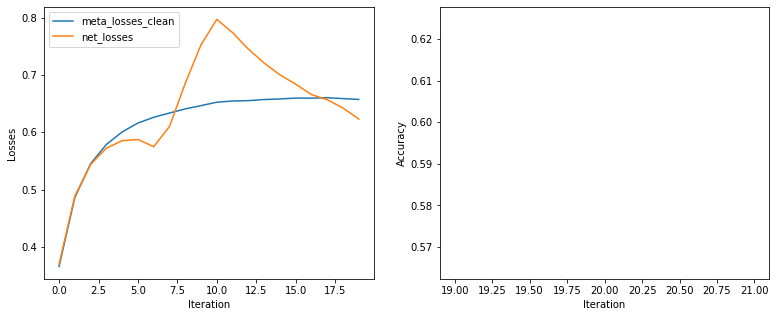

 78%|███████▊  | 39/50 [00:57<00:15,  1.45s/it]

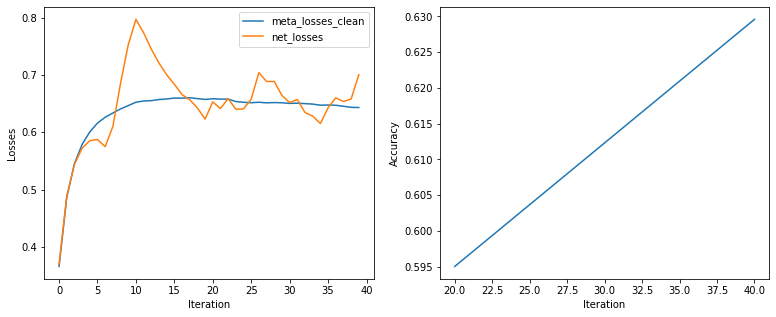

  0%|          | 0/50 [00:00<?, ?it/s]


overall TPR : 0.484
priv TPR : 0.470
unpriv TPR : 0.520
Eq. Opp : 0.051

overall FPR : 0.235
priv FPR : 0.257
unpriv FPR : 0.221
diff FPR : 0.036

overall ACC : 0.633
priv ACC : 0.656
unpriv ACC : 0.621
diff ACC : 0.035



balanced acc : 0.5
disparate_impact : 1.0
theil_index : 0.05880034498893753
statistical_parity_difference : 0.0
generalized_entropy_index :  0.05911827739236928


 38%|███▊      | 19/50 [00:28<00:45,  1.48s/it]

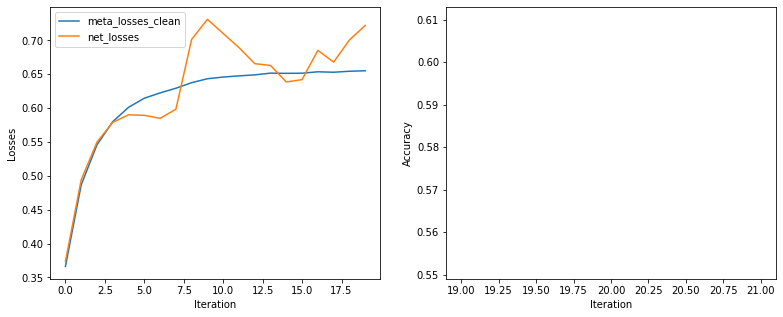

 78%|███████▊  | 39/50 [00:58<00:16,  1.49s/it]

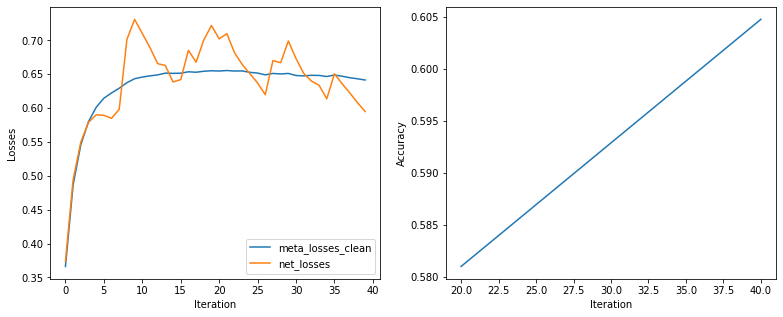

  0%|          | 0/50 [00:00<?, ?it/s]


overall TPR : 0.444
priv TPR : 0.434
unpriv TPR : 0.464
Eq. Opp : 0.030

overall FPR : 0.272
priv FPR : 0.274
unpriv FPR : 0.270
diff FPR : 0.003

overall ACC : 0.605
priv ACC : 0.623
unpriv ACC : 0.594
diff ACC : 0.029



balanced acc : 0.5
disparate_impact : 1.0
theil_index : 0.05880034498893753
statistical_parity_difference : 0.0
generalized_entropy_index :  0.05911827739236928


 38%|███▊      | 19/50 [00:28<00:47,  1.54s/it]

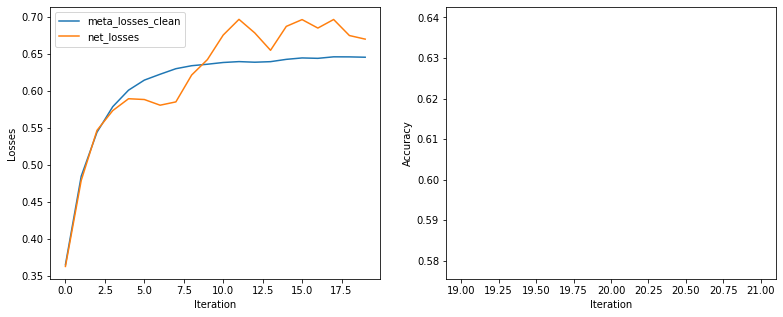

 78%|███████▊  | 39/50 [01:00<00:16,  1.50s/it]

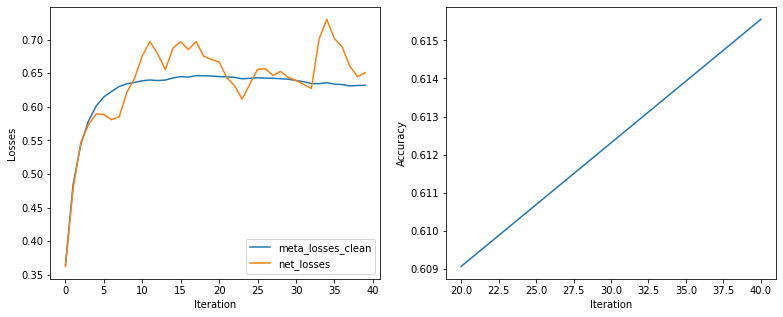

  0%|          | 0/50 [00:00<?, ?it/s]


overall TPR : 0.496
priv TPR : 0.508
unpriv TPR : 0.466
Eq. Opp : 0.042

overall FPR : 0.291
priv FPR : 0.381
unpriv FPR : 0.229
diff FPR : 0.153

overall ACC : 0.606
priv ACC : 0.557
unpriv ACC : 0.632
diff ACC : 0.075



balanced acc : 0.5
disparate_impact : 1.0
theil_index : 0.058246250183701664
statistical_parity_difference : 0.0
generalized_entropy_index :  0.05809979083463487


 38%|███▊      | 19/50 [00:29<00:47,  1.54s/it]

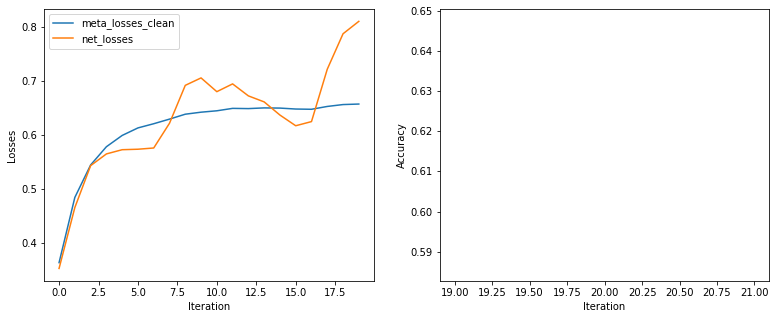

 78%|███████▊  | 39/50 [01:00<00:16,  1.52s/it]

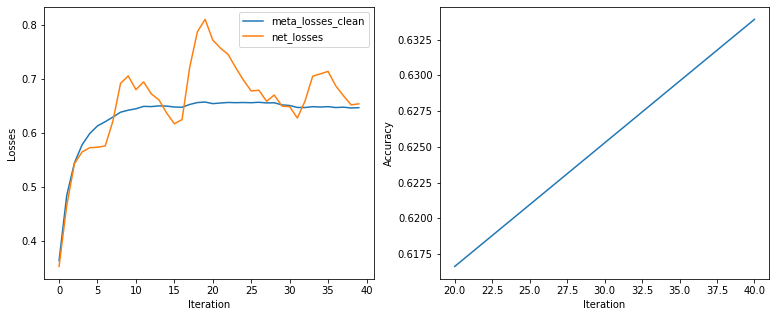

  0%|          | 0/50 [00:00<?, ?it/s]


overall TPR : 0.590
priv TPR : 0.582
unpriv TPR : 0.608
Eq. Opp : 0.026

overall FPR : 0.306
priv FPR : 0.340
unpriv FPR : 0.285
diff FPR : 0.055

overall ACC : 0.648
priv ACC : 0.641
unpriv ACC : 0.652
diff ACC : 0.011



balanced acc : 0.5
disparate_impact : 1.0
theil_index : 0.058087917031861704
statistical_parity_difference : 0.0
generalized_entropy_index :  0.05782837319958362


 38%|███▊      | 19/50 [00:29<00:47,  1.54s/it]

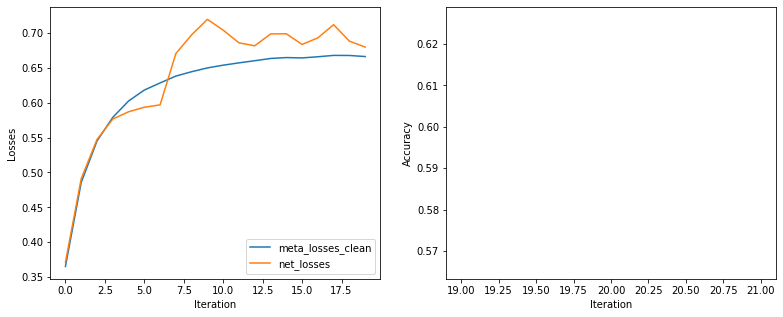

 56%|█████▌    | 28/50 [00:44<00:34,  1.56s/it]Traceback (most recent call last):
  File "/home/taeuk/anaconda3/envs/main/lib/python3.6/multiprocessing/util.py", line 262, in _run_finalizers
    finalizer()
  File "/home/taeuk/anaconda3/envs/main/lib/python3.6/multiprocessing/util.py", line 186, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/home/taeuk/anaconda3/envs/main/lib/python3.6/shutil.py", line 490, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/home/taeuk/anaconda3/envs/main/lib/python3.6/shutil.py", line 488, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-f_4sekpg'
 78%|███████▊  | 39/50 [01:00<00:16,  1.53s/it]

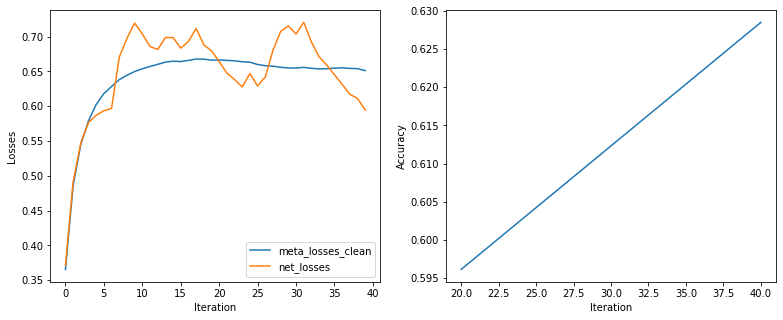

  0%|          | 0/50 [00:00<?, ?it/s]


overall TPR : 0.433
priv TPR : 0.428
unpriv TPR : 0.444
Eq. Opp : 0.015

overall FPR : 0.211
priv FPR : 0.236
unpriv FPR : 0.196
diff FPR : 0.040

overall ACC : 0.626
priv ACC : 0.634
unpriv ACC : 0.623
diff ACC : 0.011



balanced acc : 0.5
disparate_impact : 1.0
theil_index : 0.058607628813546725
statistical_parity_difference : 0.0
generalized_entropy_index :  0.05874923557743221
poi ratio: 0.2


 38%|███▊      | 19/50 [00:29<00:48,  1.57s/it]

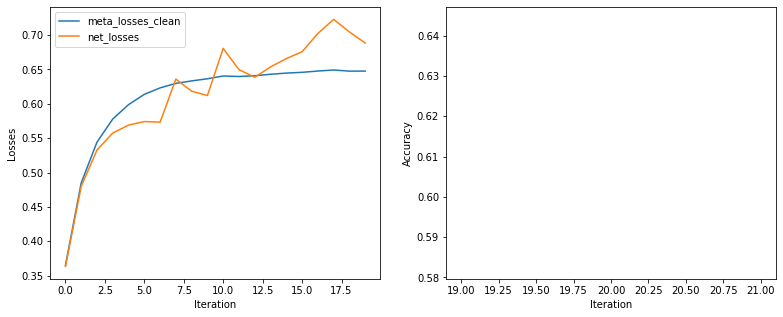

 78%|███████▊  | 39/50 [01:01<00:17,  1.57s/it]

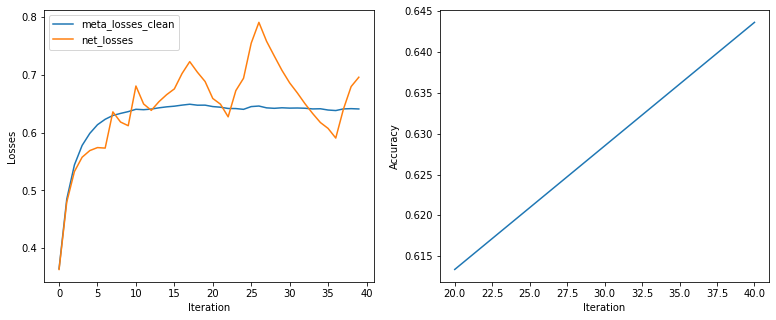

  0%|          | 0/50 [00:00<?, ?it/s]


overall TPR : 0.576
priv TPR : 0.597
unpriv TPR : 0.530
Eq. Opp : 0.067

overall FPR : 0.307
priv FPR : 0.351
unpriv FPR : 0.280
diff FPR : 0.071

overall ACC : 0.638
priv ACC : 0.599
unpriv ACC : 0.659
diff ACC : 0.060



balanced acc : 0.5
disparate_impact : 1.0
theil_index : 0.058738144251151585
statistical_parity_difference : 0.0
generalized_entropy_index :  0.05899702217777576


 38%|███▊      | 19/50 [00:30<00:49,  1.59s/it]

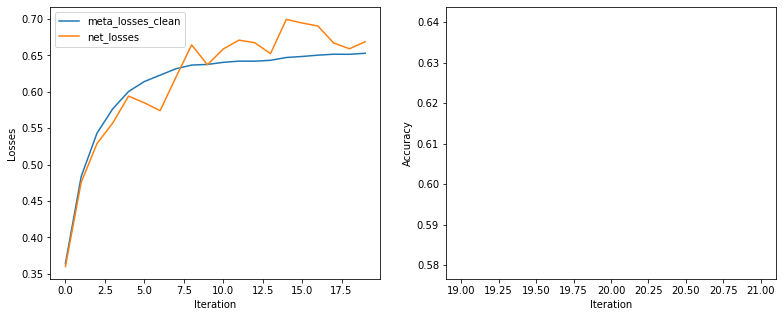

 78%|███████▊  | 39/50 [01:03<00:17,  1.59s/it]

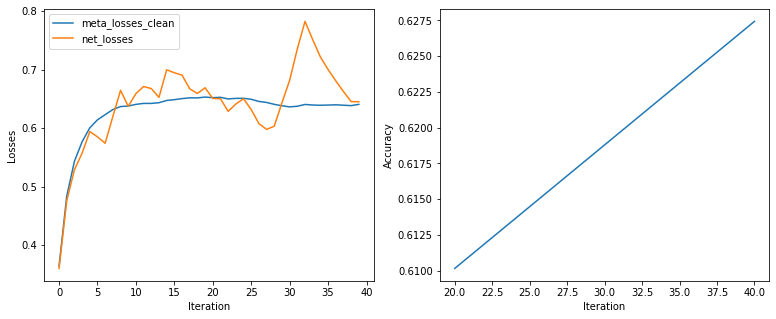

  0%|          | 0/50 [00:00<?, ?it/s]


overall TPR : 0.523
priv TPR : 0.537
unpriv TPR : 0.492
Eq. Opp : 0.046

overall FPR : 0.286
priv FPR : 0.330
unpriv FPR : 0.262
diff FPR : 0.068

overall ACC : 0.634
priv ACC : 0.603
unpriv ACC : 0.650
diff ACC : 0.047



balanced acc : 0.5
disparate_impact : 1.0
theil_index : 0.05846904394734252
statistical_parity_difference : 0.0
generalized_entropy_index :  0.0584945290725521


 38%|███▊      | 19/50 [00:30<00:50,  1.62s/it]

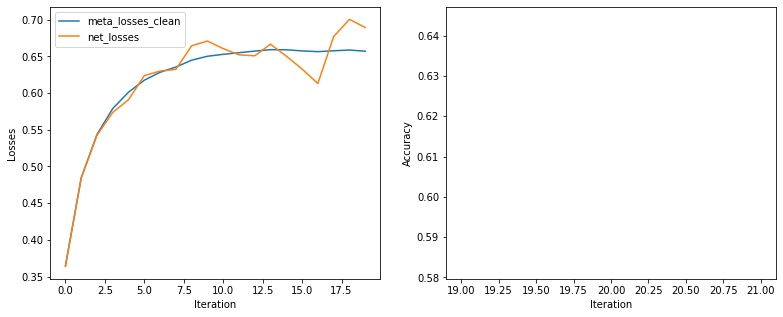

 78%|███████▊  | 39/50 [01:03<00:17,  1.58s/it]Traceback (most recent call last):
  File "/home/taeuk/anaconda3/envs/main/lib/python3.6/multiprocessing/util.py", line 262, in _run_finalizers
    finalizer()
  File "/home/taeuk/anaconda3/envs/main/lib/python3.6/multiprocessing/util.py", line 186, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/home/taeuk/anaconda3/envs/main/lib/python3.6/shutil.py", line 490, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/home/taeuk/anaconda3/envs/main/lib/python3.6/shutil.py", line 488, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-c5jzog5k'


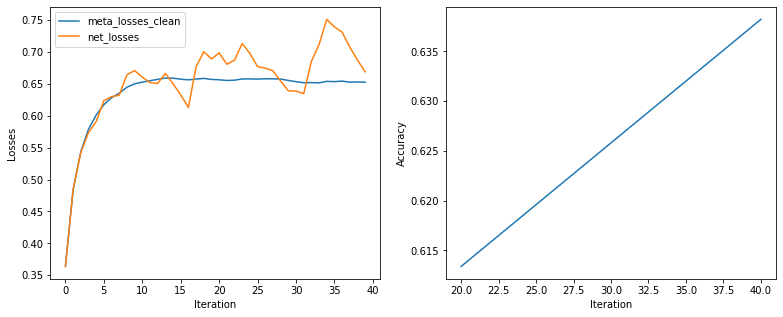

  0%|          | 0/50 [00:00<?, ?it/s]


overall TPR : 0.593
priv TPR : 0.583
unpriv TPR : 0.624
Eq. Opp : 0.041

overall FPR : 0.337
priv FPR : 0.341
unpriv FPR : 0.334
diff FPR : 0.006

overall ACC : 0.631
priv ACC : 0.646
unpriv ACC : 0.624
diff ACC : 0.022



balanced acc : 0.5
disparate_impact : 1.0
theil_index : 0.0578791375940043
statistical_parity_difference : 0.0
generalized_entropy_index :  0.057480038209336164


 38%|███▊      | 19/50 [00:30<00:50,  1.62s/it]

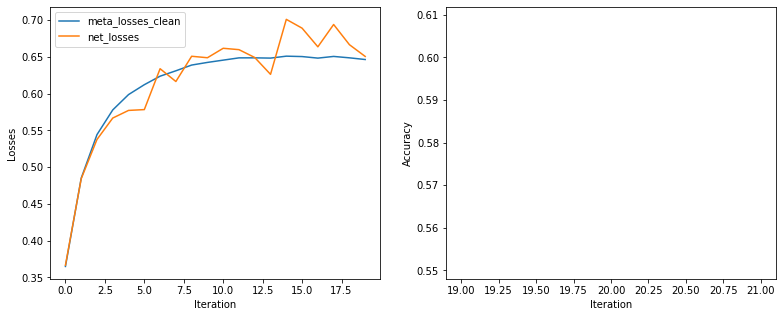

 44%|████▍     | 22/50 [00:36<00:48,  1.75s/it]Traceback (most recent call last):
  File "/home/taeuk/anaconda3/envs/main/lib/python3.6/multiprocessing/util.py", line 262, in _run_finalizers
    finalizer()
  File "/home/taeuk/anaconda3/envs/main/lib/python3.6/multiprocessing/util.py", line 186, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/home/taeuk/anaconda3/envs/main/lib/python3.6/shutil.py", line 490, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/home/taeuk/anaconda3/envs/main/lib/python3.6/shutil.py", line 488, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-rkml32__'
 78%|███████▊  | 39/50 [01:04<00:18,  1.65s/it]

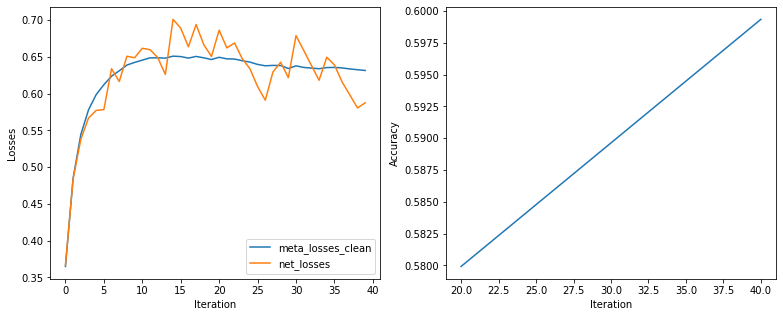

  0%|          | 0/50 [00:00<?, ?it/s]


overall TPR : 0.395
priv TPR : 0.382
unpriv TPR : 0.422
Eq. Opp : 0.040

overall FPR : 0.217
priv FPR : 0.235
unpriv FPR : 0.205
diff FPR : 0.030

overall ACC : 0.609
priv ACC : 0.628
unpriv ACC : 0.598
diff ACC : 0.030



balanced acc : 0.5
disparate_impact : 1.0
theil_index : 0.05867390137904974
statistical_parity_difference : 0.0
generalized_entropy_index :  0.05887400245011756


 38%|███▊      | 19/50 [00:31<00:50,  1.64s/it]

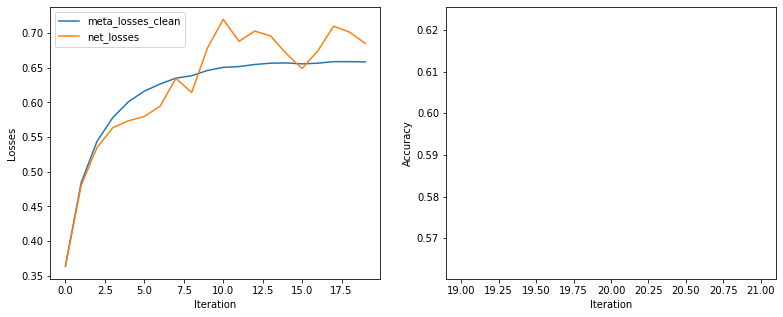

 78%|███████▊  | 39/50 [01:05<00:18,  1.64s/it]

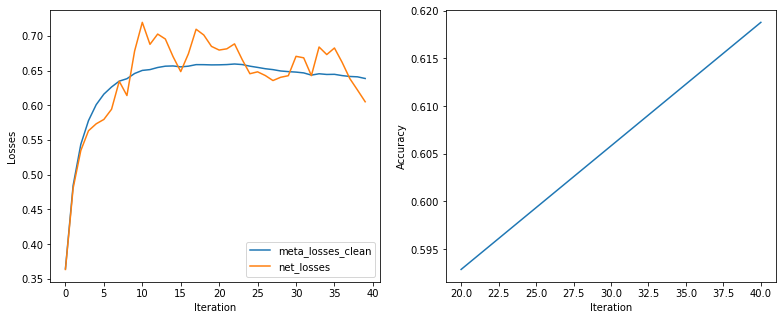

  0%|          | 0/50 [00:00<?, ?it/s]


overall TPR : 0.486
priv TPR : 0.505
unpriv TPR : 0.439
Eq. Opp : 0.066

overall FPR : 0.273
priv FPR : 0.337
unpriv FPR : 0.235
diff FPR : 0.101

overall ACC : 0.614
priv ACC : 0.573
unpriv ACC : 0.635
diff ACC : 0.062



balanced acc : 0.5
disparate_impact : 1.0
theil_index : 0.059001784156442035
statistical_parity_difference : 0.0
generalized_entropy_index :  0.059528520549494035
poi ratio: 0.30000000000000004


 38%|███▊      | 19/50 [00:31<00:51,  1.65s/it]

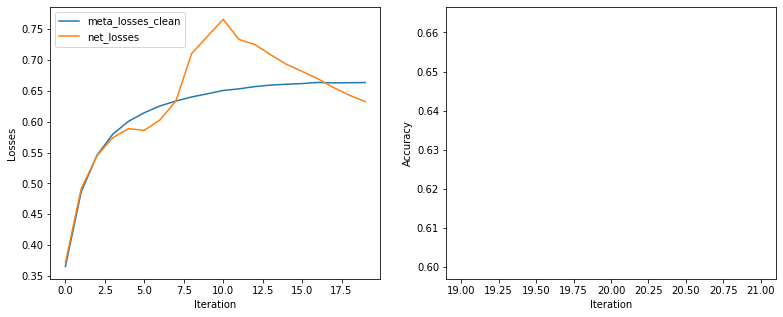

 78%|███████▊  | 39/50 [01:05<00:18,  1.65s/it]

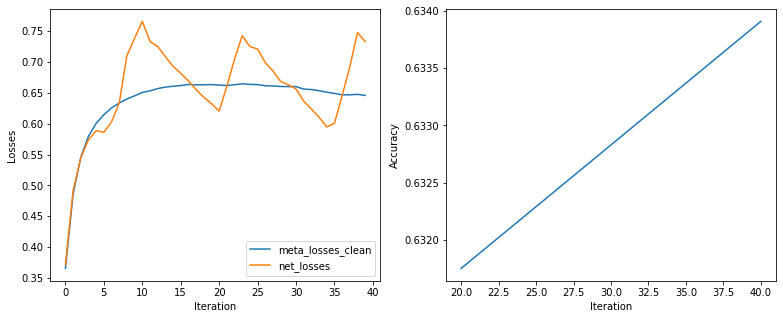

  0%|          | 0/50 [00:00<?, ?it/s]


overall TPR : 0.463
priv TPR : 0.480
unpriv TPR : 0.415
Eq. Opp : 0.065

overall FPR : 0.242
priv FPR : 0.212
unpriv FPR : 0.258
diff FPR : 0.046

overall ACC : 0.627
priv ACC : 0.649
unpriv ACC : 0.618
diff ACC : 0.031



balanced acc : 0.5
disparate_impact : 1.0
theil_index : 0.05839675611181068
statistical_parity_difference : 0.0
generalized_entropy_index :  0.05836462338464487


 38%|███▊      | 19/50 [00:31<00:51,  1.66s/it]

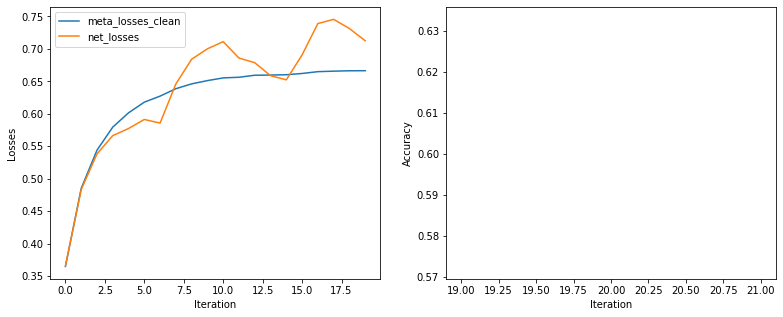

 78%|███████▊  | 39/50 [01:05<00:18,  1.68s/it]

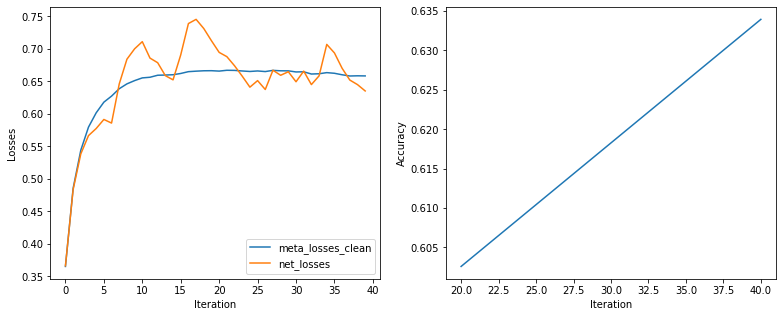

  0%|          | 0/50 [00:00<?, ?it/s]


overall TPR : 0.520
priv TPR : 0.546
unpriv TPR : 0.455
Eq. Opp : 0.090

overall FPR : 0.282
priv FPR : 0.337
unpriv FPR : 0.248
diff FPR : 0.089

overall ACC : 0.626
priv ACC : 0.581
unpriv ACC : 0.649
diff ACC : 0.068



balanced acc : 0.5
disparate_impact : 1.0
theil_index : 0.058168056066928826
statistical_parity_difference : 0.0
generalized_entropy_index :  0.05796489699214348


 16%|█▌        | 8/50 [00:13<01:10,  1.67s/it]Traceback (most recent call last):
  File "/home/taeuk/anaconda3/envs/main/lib/python3.6/multiprocessing/util.py", line 262, in _run_finalizers
    finalizer()
  File "/home/taeuk/anaconda3/envs/main/lib/python3.6/multiprocessing/util.py", line 186, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/home/taeuk/anaconda3/envs/main/lib/python3.6/shutil.py", line 490, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/home/taeuk/anaconda3/envs/main/lib/python3.6/shutil.py", line 488, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-2ajxs0qc'
 24%|██▍       | 12/50 [00:20<01:03,  1.67s/it]Traceback (most recent call last):
  File "/home/taeuk/anaconda3/envs/main/lib/python3.6/multiprocessing/util.py", line 262, in _run_finalizers
    finalizer()
  File "/home/taeuk/anaconda3/envs/main/lib/python3.6/multiprocessing/util.py", line 186, in __call__
    res = self._callback(*self._

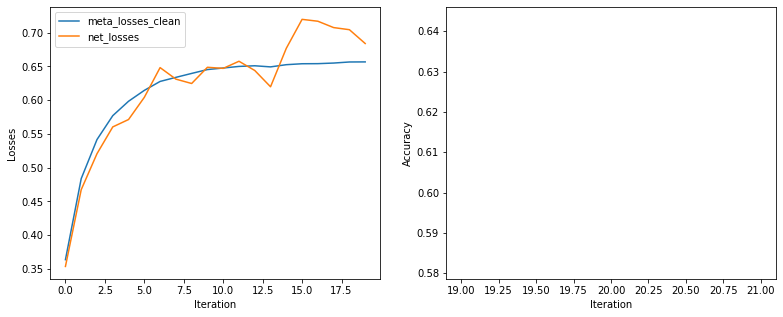

 78%|███████▊  | 39/50 [01:06<00:18,  1.67s/it]

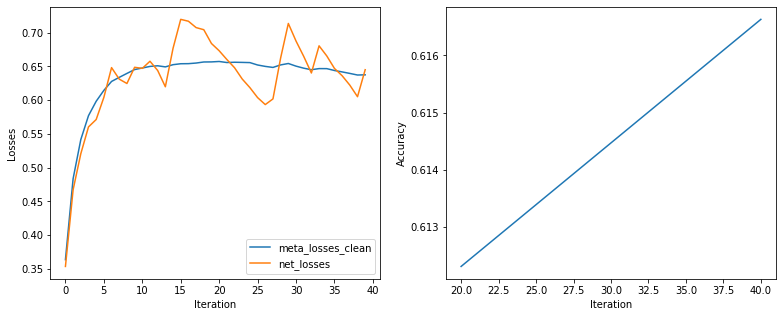

  0%|          | 0/50 [00:00<?, ?it/s]


overall TPR : 0.420
priv TPR : 0.416
unpriv TPR : 0.429
Eq. Opp : 0.012

overall FPR : 0.215
priv FPR : 0.253
unpriv FPR : 0.191
diff FPR : 0.062

overall ACC : 0.618
priv ACC : 0.623
unpriv ACC : 0.615
diff ACC : 0.009



balanced acc : 0.5
disparate_impact : 1.0
theil_index : 0.05850444129844595
statistical_parity_difference : 0.0
generalized_entropy_index :  0.05855884697160042


  6%|▌         | 3/50 [00:05<01:21,  1.74s/it]Traceback (most recent call last):
  File "/home/taeuk/anaconda3/envs/main/lib/python3.6/multiprocessing/util.py", line 262, in _run_finalizers
    finalizer()
  File "/home/taeuk/anaconda3/envs/main/lib/python3.6/multiprocessing/util.py", line 186, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/home/taeuk/anaconda3/envs/main/lib/python3.6/shutil.py", line 490, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/home/taeuk/anaconda3/envs/main/lib/python3.6/shutil.py", line 488, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-f0zcuemu'
 38%|███▊      | 19/50 [00:36<01:04,  2.09s/it]

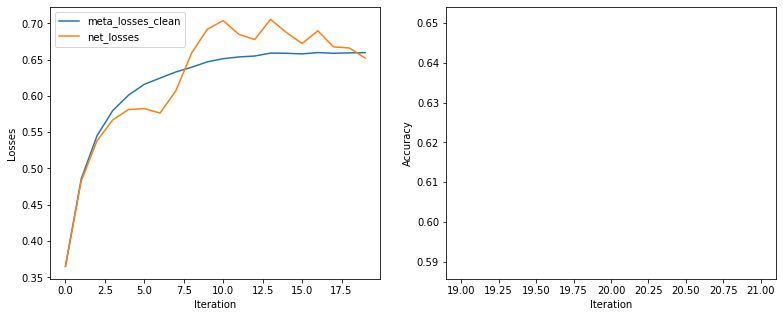

 78%|███████▊  | 39/50 [01:13<00:18,  1.71s/it]

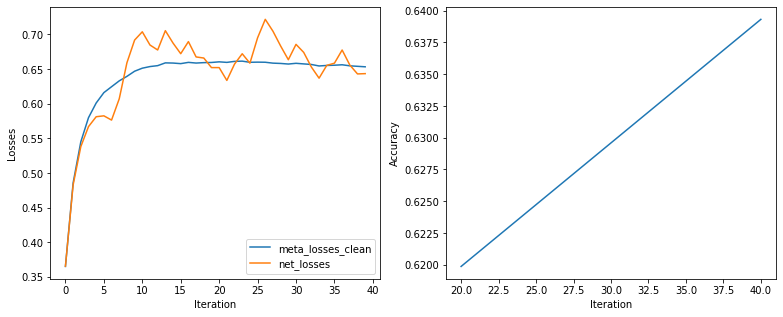

  0%|          | 0/50 [00:00<?, ?it/s]


overall TPR : 0.507
priv TPR : 0.524
unpriv TPR : 0.471
Eq. Opp : 0.053

overall FPR : 0.237
priv FPR : 0.264
unpriv FPR : 0.218
diff FPR : 0.047

overall ACC : 0.646
priv ACC : 0.630
unpriv ACC : 0.655
diff ACC : 0.025



balanced acc : 0.5
disparate_impact : 1.0
theil_index : 0.05886049106695558
statistical_parity_difference : 0.0
generalized_entropy_index :  0.05923775056460331


 38%|███▊      | 19/50 [00:32<00:55,  1.77s/it]

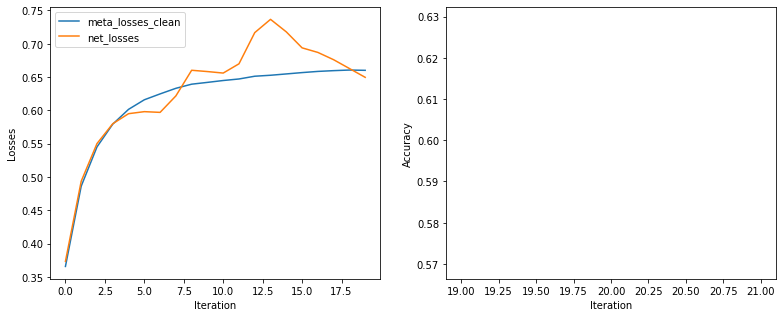

 78%|███████▊  | 39/50 [01:08<00:18,  1.72s/it]

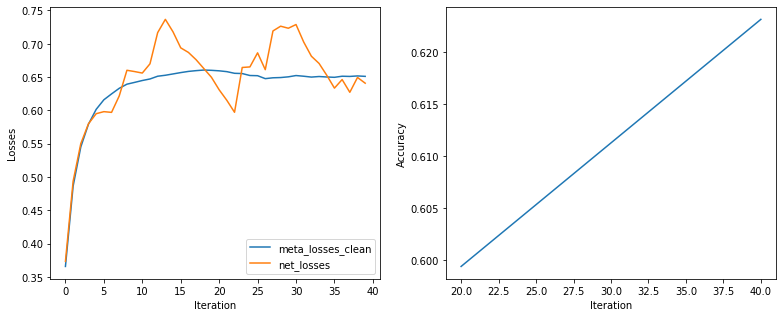

  0%|          | 0/50 [00:00<?, ?it/s]


overall TPR : 0.450
priv TPR : 0.466
unpriv TPR : 0.409
Eq. Opp : 0.057

overall FPR : 0.261
priv FPR : 0.269
unpriv FPR : 0.257
diff FPR : 0.012

overall ACC : 0.613
priv ACC : 0.616
unpriv ACC : 0.612
diff ACC : 0.003



balanced acc : 0.5
disparate_impact : 1.0
theil_index : 0.058539338911693155
statistical_parity_difference : 0.0
generalized_entropy_index :  0.058622738768120894
poi ratio: 0.4


 38%|███▊      | 19/50 [00:33<00:54,  1.75s/it]

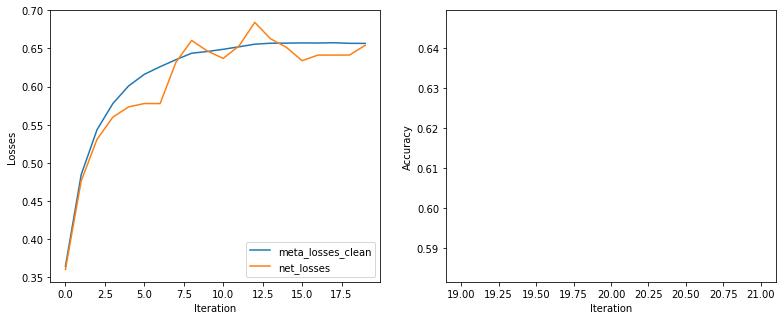

 78%|███████▊  | 39/50 [01:09<00:19,  1.75s/it]

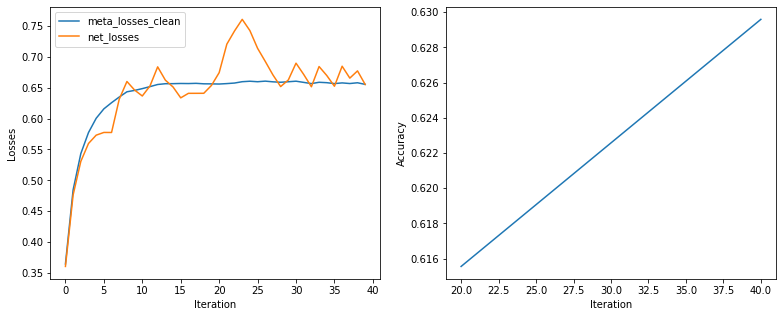

  0%|          | 0/50 [00:00<?, ?it/s]


overall TPR : 0.432
priv TPR : 0.437
unpriv TPR : 0.417
Eq. Opp : 0.020

overall FPR : 0.246
priv FPR : 0.258
unpriv FPR : 0.240
diff FPR : 0.018

overall ACC : 0.616
priv ACC : 0.626
unpriv ACC : 0.611
diff ACC : 0.016



balanced acc : 0.5
disparate_impact : 1.0
theil_index : 0.05900178415644203
statistical_parity_difference : 0.0
generalized_entropy_index :  0.05952852054949403


 38%|███▊      | 19/50 [00:33<00:54,  1.76s/it]

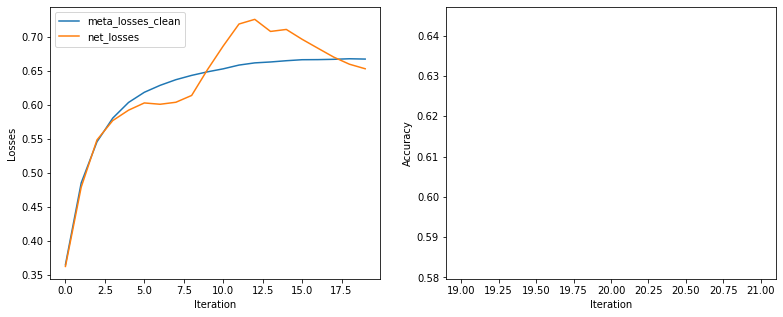

 78%|███████▊  | 39/50 [01:09<00:19,  1.75s/it]

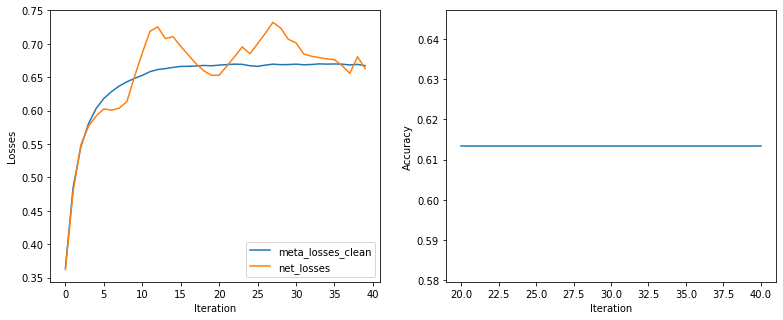

  0%|          | 0/50 [00:00<?, ?it/s]


overall TPR : 0.521
priv TPR : 0.531
unpriv TPR : 0.500
Eq. Opp : 0.031

overall FPR : 0.301
priv FPR : 0.295
unpriv FPR : 0.305
diff FPR : 0.010

overall ACC : 0.617
priv ACC : 0.621
unpriv ACC : 0.614
diff ACC : 0.006



balanced acc : 0.5
disparate_impact : 1.0
theil_index : 0.05756689420880565
statistical_parity_difference : 0.0
generalized_entropy_index :  0.056975894813732594


 38%|███▊      | 19/50 [00:33<00:54,  1.76s/it]

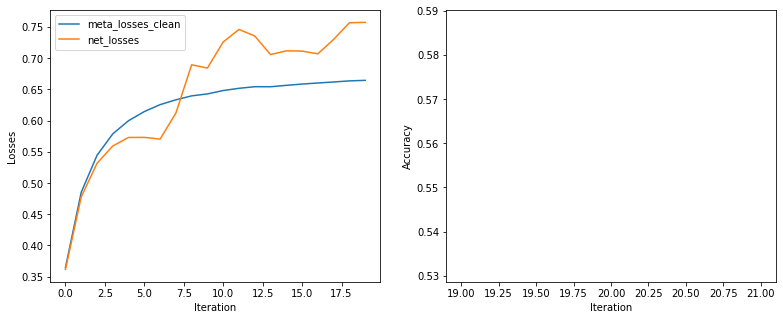

 78%|███████▊  | 39/50 [01:10<00:20,  1.82s/it]

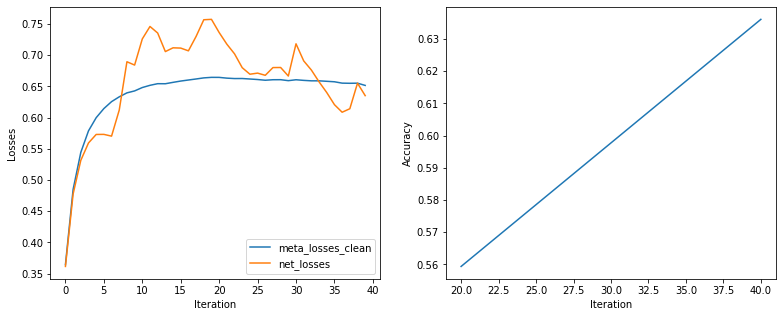

  0%|          | 0/50 [00:00<?, ?it/s]


overall TPR : 0.510
priv TPR : 0.522
unpriv TPR : 0.480
Eq. Opp : 0.043

overall FPR : 0.239
priv FPR : 0.265
unpriv FPR : 0.224
diff FPR : 0.041

overall ACC : 0.643
priv ACC : 0.633
unpriv ACC : 0.647
diff ACC : 0.014



balanced acc : 0.5
disparate_impact : 1.0
theil_index : 0.058830675646579005
statistical_parity_difference : 0.0
generalized_entropy_index :  0.05917823783570594


 38%|███▊      | 19/50 [00:33<00:54,  1.77s/it]

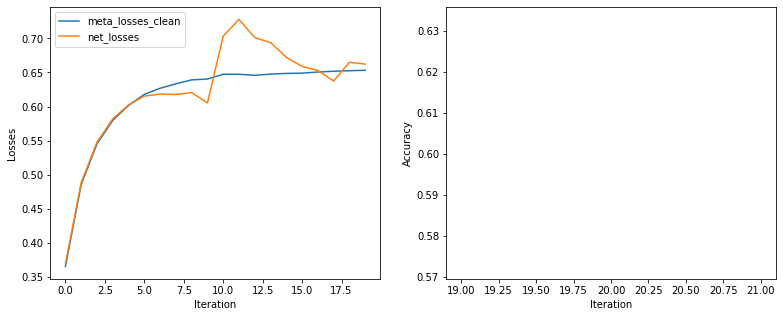

 74%|███████▍  | 37/50 [01:07<00:23,  1.77s/it]Traceback (most recent call last):
  File "/home/taeuk/anaconda3/envs/main/lib/python3.6/multiprocessing/util.py", line 262, in _run_finalizers
    finalizer()
  File "/home/taeuk/anaconda3/envs/main/lib/python3.6/multiprocessing/util.py", line 186, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/home/taeuk/anaconda3/envs/main/lib/python3.6/shutil.py", line 490, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/home/taeuk/anaconda3/envs/main/lib/python3.6/shutil.py", line 488, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-15ehj3y3'
 78%|███████▊  | 39/50 [01:10<00:19,  1.80s/it]

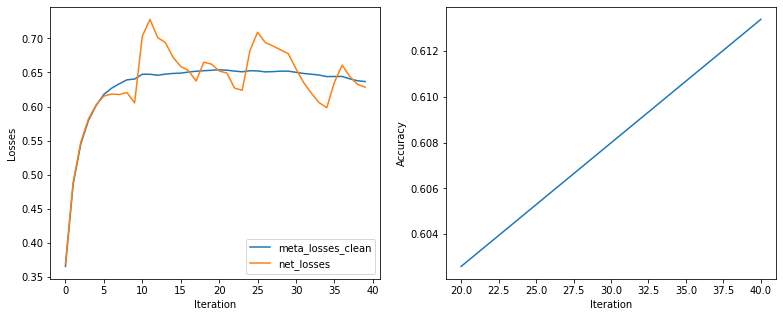

  0%|          | 0/50 [00:00<?, ?it/s]


overall TPR : 0.525
priv TPR : 0.536
unpriv TPR : 0.496
Eq. Opp : 0.041

overall FPR : 0.274
priv FPR : 0.343
unpriv FPR : 0.228
diff FPR : 0.115

overall ACC : 0.635
priv ACC : 0.598
unpriv ACC : 0.655
diff ACC : 0.056



balanced acc : 0.5
disparate_impact : 1.0
theil_index : 0.058607628813546725
statistical_parity_difference : 0.0
generalized_entropy_index :  0.0587492355774322


 38%|███▊      | 19/50 [00:34<00:56,  1.82s/it]

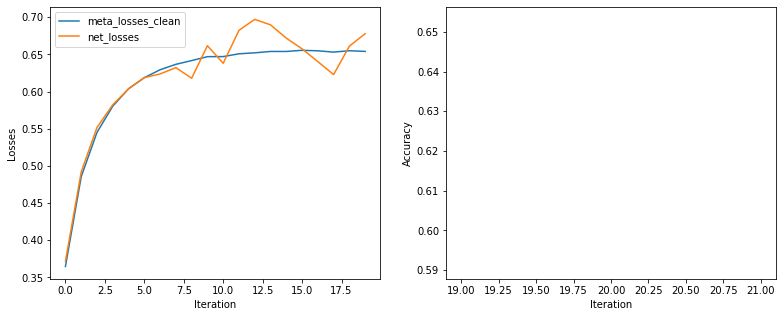

 78%|███████▊  | 39/50 [01:11<00:19,  1.80s/it]

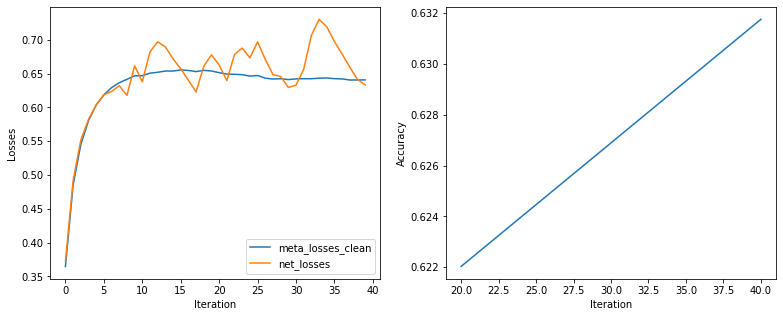

  0%|          | 0/50 [00:00<?, ?it/s]


overall TPR : 0.603
priv TPR : 0.603
unpriv TPR : 0.605
Eq. Opp : 0.002

overall FPR : 0.322
priv FPR : 0.369
unpriv FPR : 0.294
diff FPR : 0.075

overall ACC : 0.643
priv ACC : 0.620
unpriv ACC : 0.653
diff ACC : 0.033



balanced acc : 0.5
disparate_impact : 1.0
theil_index : 0.05671446575411319
statistical_parity_difference : 0.0
generalized_entropy_index :  0.05567528511251459
poi ratio: 0.5


 38%|███▊      | 19/50 [00:34<00:57,  1.86s/it]

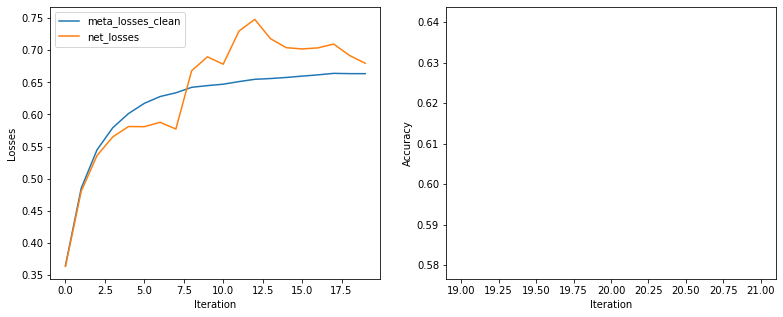

 78%|███████▊  | 39/50 [01:12<00:20,  1.85s/it]

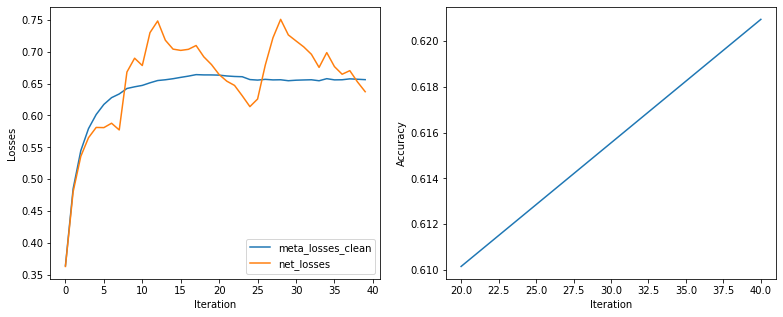

  0%|          | 0/50 [00:00<?, ?it/s]


overall TPR : 0.496
priv TPR : 0.536
unpriv TPR : 0.414
Eq. Opp : 0.122

overall FPR : 0.292
priv FPR : 0.339
unpriv FPR : 0.268
diff FPR : 0.071

overall ACC : 0.613
priv ACC : 0.554
unpriv ACC : 0.643
diff ACC : 0.089



balanced acc : 0.5
disparate_impact : 1.0
theil_index : 0.058641018033699886
statistical_parity_difference : 0.0
generalized_entropy_index :  0.058811836327655506


 38%|███▊      | 19/50 [00:35<00:57,  1.85s/it]

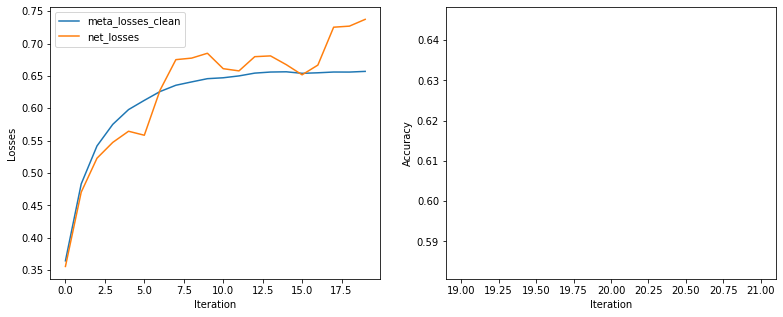

 78%|███████▊  | 39/50 [01:13<00:20,  1.84s/it]

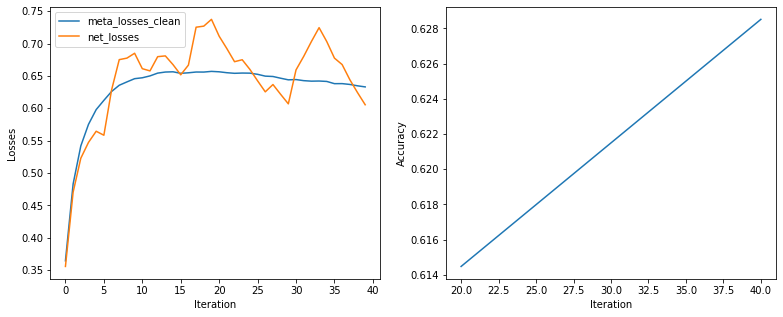

  0%|          | 0/50 [00:00<?, ?it/s]


overall TPR : 0.497
priv TPR : 0.507
unpriv TPR : 0.474
Eq. Opp : 0.034

overall FPR : 0.279
priv FPR : 0.294
unpriv FPR : 0.271
diff FPR : 0.023

overall ACC : 0.626
priv ACC : 0.620
unpriv ACC : 0.629
diff ACC : 0.009



balanced acc : 0.5
disparate_impact : 1.0
theil_index : 0.05812822892555994
statistical_parity_difference : 0.0
generalized_entropy_index :  0.05789683782772521


 38%|███▊      | 19/50 [00:35<00:58,  1.88s/it]

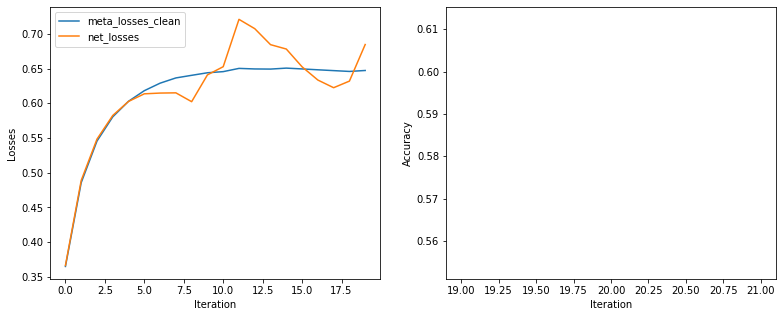

 78%|███████▊  | 39/50 [01:14<00:20,  1.86s/it]

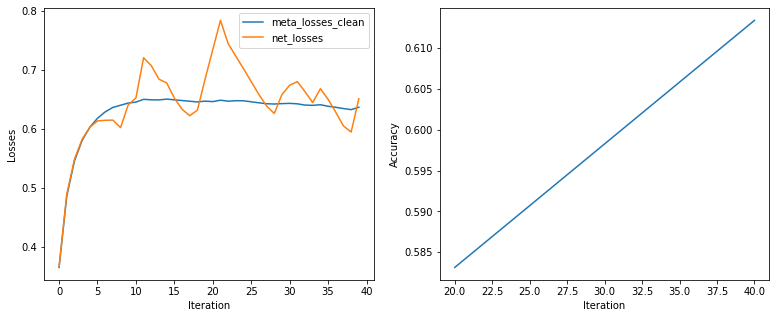

  0%|          | 0/50 [00:00<?, ?it/s]


overall TPR : 0.475
priv TPR : 0.473
unpriv TPR : 0.479
Eq. Opp : 0.006

overall FPR : 0.303
priv FPR : 0.338
unpriv FPR : 0.280
diff FPR : 0.058

overall ACC : 0.600
priv ACC : 0.594
unpriv ACC : 0.604
diff ACC : 0.010



balanced acc : 0.5
disparate_impact : 1.0
theil_index : 0.05843314837972304
statistical_parity_difference : 0.0
generalized_entropy_index :  0.05842978717783892


 38%|███▊      | 19/50 [00:35<00:57,  1.85s/it]

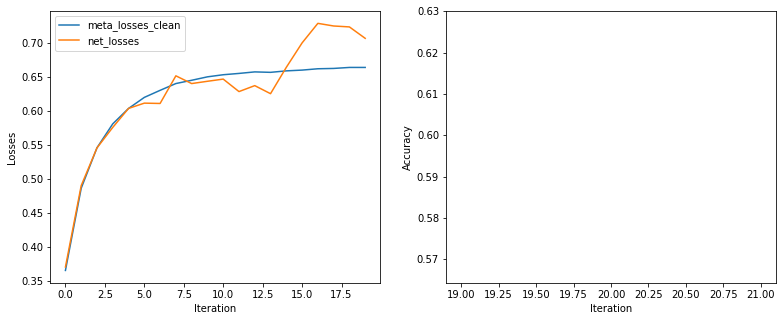

 78%|███████▊  | 39/50 [01:14<00:20,  1.88s/it]

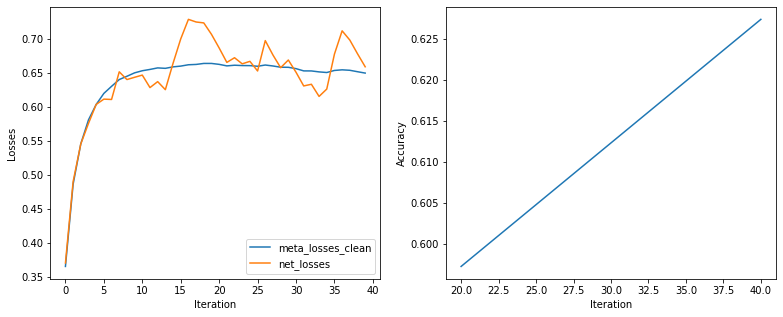

  0%|          | 0/50 [00:00<?, ?it/s]


overall TPR : 0.460
priv TPR : 0.462
unpriv TPR : 0.456
Eq. Opp : 0.006

overall FPR : 0.255
priv FPR : 0.301
unpriv FPR : 0.230
diff FPR : 0.071

overall ACC : 0.614
priv ACC : 0.598
unpriv ACC : 0.622
diff ACC : 0.024



balanced acc : 0.5
disparate_impact : 1.0
theil_index : 0.05867390137904973
statistical_parity_difference : 0.0
generalized_entropy_index :  0.05887400245011755


 38%|███▊      | 19/50 [00:36<01:00,  1.94s/it]

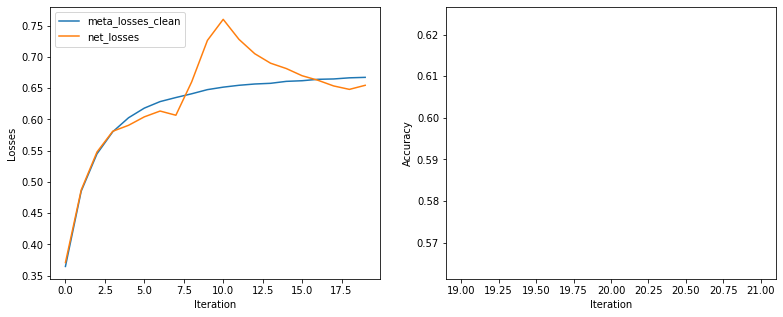

 78%|███████▊  | 39/50 [01:15<00:20,  1.90s/it]

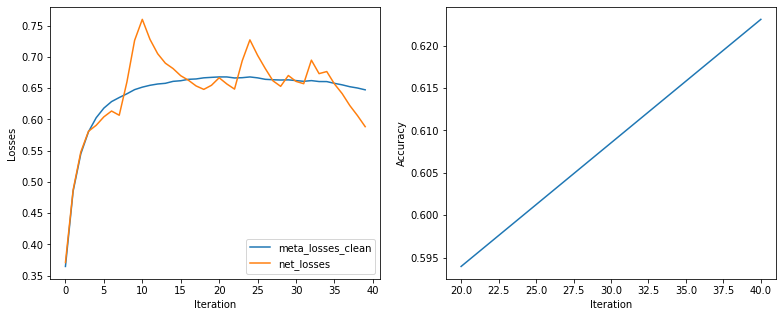

 90%|█████████ | 45/50 [01:27<00:09,  1.99s/it]Traceback (most recent call last):
  File "/home/taeuk/anaconda3/envs/main/lib/python3.6/multiprocessing/util.py", line 262, in _run_finalizers
    finalizer()
  File "/home/taeuk/anaconda3/envs/main/lib/python3.6/multiprocessing/util.py", line 186, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/home/taeuk/anaconda3/envs/main/lib/python3.6/shutil.py", line 490, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/home/taeuk/anaconda3/envs/main/lib/python3.6/shutil.py", line 488, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-685zxj2f'
100%|██████████| 50/50 [01:37<00:00,  1.94s/it]



overall TPR : 0.509
priv TPR : 0.497
unpriv TPR : 0.545
Eq. Opp : 0.048

overall FPR : 0.272
priv FPR : 0.256
unpriv FPR : 0.281
diff FPR : 0.025

overall ACC : 0.623
priv ACC : 0.668
unpriv ACC : 0.603
diff ACC : 0.065



balanced acc : 0.5
disparate_impact : 1.0
theil_index : 0.05824625018370166
statistical_parity_difference : 0.0
generalized_entropy_index :  0.05809979083463489


In [18]:
results_dict = {}
for poi_ratio in np.linspace(0.1, 0.5, 5):
    print('poi ratio:', poi_ratio)
    results_dict[poi_ratio] = {}
    results_dict[poi_ratio]['EqOdds'] =[]
    results_dict[poi_ratio]['Acc'] = []
    results_dict[poi_ratio]['DISP'] = []
    results_dict[poi_ratio]['EqOpp']= []
    results_dict[poi_ratio]['Acc_diff'] = []

    results_dict[poi_ratio]['total_tpr'] =[]
    results_dict[poi_ratio]['total_fpr'] =[]

    results_dict[poi_ratio]['total_tpr_priv'] =[]
    results_dict[poi_ratio]['total_tpr_unpriv'] =[]
    results_dict[poi_ratio]['total_fpr_priv'] =[]
    results_dict[poi_ratio]['total_fpr_unpriv'] =[]

    for repeat in range(5):
        epochs = range(1, 51)
        data_train, data_vt = dataset[data_name].split([0.7], shuffle=True)
        data_valid, data_test = data_vt.split([0.5], shuffle=True)

        input_size = dataset[data_name].features.shape[-1] - 1
        latent_size = 512
        hidden_size = 512

        idx = np.where(data_train.features[:, sens_idx] == 1)[0]
        poison_idx = np.random.permutation(idx)[:int(len(idx) * poi_ratio)]

        #label poisoning
        data_train.labels[poison_idx] = abs(1 - data_train.labels[poison_idx])

        d_train = Dataset(data_train, sens_idx)
        d_valid = Dataset(data_valid, sens_idx)
        d_test = Dataset(data_test, sens_idx)


        #bs_train, bs_valid, bs_test = len(d_train), len(d_valid), len(d_test)
        bs_train, bs_valid, bs_test = 256, 256, 256
        # bs_train, bs_valid, bs_test = 64, 64, 64

        trainloader = torch.utils.data.DataLoader(
            d_train,
            batch_size=bs_train,
            shuffle=True,
            num_workers=workers)

        validloader = torch.utils.data.DataLoader(
            d_valid,
            batch_size=bs_valid,
            shuffle=True,
            num_workers=workers)
        testloader = torch.utils.data.DataLoader(
            d_test,
            batch_size=bs_test,
            shuffle=True,
            num_workers=workers)


        train_LWE(results_dict)

In [19]:
results_dict

{0.1: {'EqOdds': [tensor([0.0865], device='cuda:0'),
   tensor([0.0333], device='cuda:0'),
   tensor([0.1948], device='cuda:0'),
   tensor([0.0812], device='cuda:0'),
   tensor([0.0555], device='cuda:0')],
  'Acc': [tensor([0.6328], device='cuda:0'),
   tensor([0.6048], device='cuda:0'),
   tensor([0.6058], device='cuda:0'),
   tensor([0.6479], device='cuda:0'),
   tensor([0.6263], device='cuda:0')],
  'DISP': [1.0, 1.0, 1.0, 1.0, 1.0],
  'EqOpp': [tensor([0.0507], device='cuda:0'),
   tensor([0.0298], device='cuda:0'),
   tensor([0.0422], device='cuda:0'),
   tensor([0.0265], device='cuda:0'),
   tensor([0.0155], device='cuda:0')],
  'Acc_diff': [tensor([0.0351], device='cuda:0'),
   tensor([0.0291], device='cuda:0'),
   tensor([0.0754], device='cuda:0'),
   tensor([0.0112], device='cuda:0'),
   tensor([0.0114], device='cuda:0')],
  'total_tpr': [tensor([0.4839], device='cuda:0'),
   tensor([0.4442], device='cuda:0'),
   tensor([0.4955], device='cuda:0'),
   tensor([0.5897], device='c

In [21]:
data_name

'compas'

In [22]:
with open(f'results/{data_name}/robust_LWE_dict.pkl', 'wb') as f:
    pickle.dump(results_dict, f)

#### Poisoning

In [44]:
#COMPAS setup
results_dict = {}

for poi_ratio in np.linspace(0.1, 0.5, 5):
    data_train, data_vt = dataset[data_name].split([0.7], shuffle=True)
    data_valid, data_test = data_vt.split([0.5], shuffle=True)

    idx = np.where(data_train.features[:, sens_idx] == 1)[0]
    poison_idx = np.random.permutation(idx)[:int(len(idx) * poi_ratio)]

    #label poisoning
    data_train.labels[poison_idx] = 1 - data_train.labels[poison_idx]

    X_train = torch.FloatTensor(data_train.features[:, ~sens_loc])
    y_train = torch.FloatTensor(data_train.labels)
    s1_train = torch.FloatTensor(data_train.features[:, sens_idx]).view(-1,1)

    X_val = torch.FloatTensor(data_valid.features[:, ~sens_loc])
    y_val = torch.FloatTensor(data_valid.labels)
    s1_val = torch.FloatTensor(data_valid.features[:, sens_idx]).view(-1,1)

    X_test = torch.FloatTensor(data_test.features[:, ~sens_loc])
    y_test = torch.FloatTensor(data_test.labels)
    s1_test = torch.FloatTensor(data_test.features[:, sens_idx]).view(-1,1)

    XS_train = torch.cat([X_train, s1_train.reshape((s1_train.shape[0], 1))], dim=1)
    XS_val = torch.cat([X_val, s1_val.reshape((s1_val.shape[0], 1))], dim=1)
    XS_test = torch.cat([X_test, s1_test.reshape((s1_test.shape[0], 1))], dim=1)

    train_result = []
    train_tensors = Namespace(XS_train = XS_train, y_train = y_train, s1_train = s1_train)
    val_tensors = Namespace(XS_val = XS_val, y_val = y_val, s1_val = s1_val) 
    test_tensors = Namespace(XS_test = XS_test, y_test = y_test, s1_test = s1_test)

    train_opt = Namespace(val=len(y_val), n_epochs=200, k=1, lr_g=1e-3, lr_f=1e-4, lr_r=1e-4)
    seed = 1

    lambda_f_set = [0.1] # Lambda value for the fairness discriminator of FR-Train.
    lambda_r = 0.1 # Lambda value for the robustness discriminator of FR-Train.

    results_dict[poi_ratio] = {}
    
    data_train = Dataset(X_train, s1_train, y_train)
    data_valid = Dataset(X_val, s1_val, y_val)
    data_test = Dataset(X_test, s1_test, y_test)

    trainloader = torch.utils.data.DataLoader(
        data_train,
        batch_size=128,
        shuffle=True,
        )
    validloader = torch.utils.data.DataLoader(
        data_valid,
        batch_size=128,
        shuffle=True,
        drop_last = True
        )
    testloader = torch.utils.data.DataLoader(
        data_test,
        batch_size=128,
        shuffle=True,
        drop_last = True
        )


    for lambda_f in lambda_f_set:
        train_model_adult(results_dict[poi_ratio], train_tensors, val_tensors, test_tensors, train_opt, lambda_f = lambda_f, lambda_r = lambda_r, seed = seed)
    


[Lambda: 0.100000] [Epoch 10/200] [D_F loss: 0.694809] [D_R loss: 0.588161] [G loss: 4.766986]
VALID DATA
overall TPR : 0.224
priv TPR : 0.258
unpriv TPR : 0.148
Eq. Opp : 0.110

overall FPR : 0.139
priv FPR : 0.129
unpriv FPR : 0.145
diff FPR : 0.016

overall ACC : 0.571
priv ACC : 0.576
unpriv ACC : 0.569
diff ACC : 0.008



TEST DATA
overall TPR : 0.202
priv TPR : 0.231
unpriv TPR : 0.145
Eq. Opp : 0.086

overall FPR : 0.103
priv FPR : 0.060
unpriv FPR : 0.131
diff FPR : 0.071

overall ACC : 0.562
priv ACC : 0.588
unpriv ACC : 0.548
diff ACC : 0.041



DIMP : 0.538
[Lambda: 0.100000] [Epoch 20/200] [D_F loss: 0.690723] [D_R loss: 1.004347] [G loss: 0.204525]
VALID DATA
overall TPR : 0.716
priv TPR : 0.729
unpriv TPR : 0.690
Eq. Opp : 0.039

overall FPR : 0.495
priv FPR : 0.508
unpriv FPR : 0.487
diff FPR : 0.021

overall ACC : 0.602
priv ACC : 0.573
unpriv ACC : 0.617
diff ACC : 0.044



TEST DATA
overall TPR : 0.705
priv TPR : 0.715
unpriv TPR : 0.685
Eq. Opp : 0.030

overall FPR :

[Lambda: 0.100000] [Epoch 160/200] [D_F loss: 0.680010] [D_R loss: 0.543620] [G loss: 0.279422]
VALID DATA
overall TPR : 0.577
priv TPR : 0.616
unpriv TPR : 0.496
Eq. Opp : 0.119

overall FPR : 0.334
priv FPR : 0.324
unpriv FPR : 0.340
diff FPR : 0.016

overall ACC : 0.625
priv ACC : 0.600
unpriv ACC : 0.639
diff ACC : 0.039



TEST DATA
overall TPR : 0.594
priv TPR : 0.603
unpriv TPR : 0.577
Eq. Opp : 0.025

overall FPR : 0.325
priv FPR : 0.291
unpriv FPR : 0.347
diff FPR : 0.057

overall ACC : 0.636
priv ACC : 0.651
unpriv ACC : 0.628
diff ACC : 0.023



DIMP : 0.879
[Lambda: 0.100000] [Epoch 170/200] [D_F loss: 0.678357] [D_R loss: 0.649717] [G loss: 0.227475]
VALID DATA
overall TPR : 0.528
priv TPR : 0.583
unpriv TPR : 0.411
Eq. Opp : 0.172

overall FPR : 0.282
priv FPR : 0.214
unpriv FPR : 0.325
diff FPR : 0.111

overall ACC : 0.632
priv ACC : 0.633
unpriv ACC : 0.631
diff ACC : 0.002



TEST DATA
overall TPR : 0.551
priv TPR : 0.615
unpriv TPR : 0.423
Eq. Opp : 0.192

overall FPR

[Lambda: 0.100000] [Epoch 110/200] [D_F loss: 0.684285] [D_R loss: 0.628715] [G loss: 0.234564]
VALID DATA
overall TPR : 0.505
priv TPR : 0.582
unpriv TPR : 0.328
Eq. Opp : 0.254

overall FPR : 0.302
priv FPR : 0.326
unpriv FPR : 0.288
diff FPR : 0.037

overall ACC : 0.612
priv ACC : 0.532
unpriv ACC : 0.651
diff ACC : 0.119



TEST DATA
overall TPR : 0.484
priv TPR : 0.539
unpriv TPR : 0.362
Eq. Opp : 0.177

overall FPR : 0.249
priv FPR : 0.289
unpriv FPR : 0.224
diff FPR : 0.065

overall ACC : 0.629
priv ACC : 0.571
unpriv ACC : 0.661
diff ACC : 0.091



DIMP : 0.846
[Lambda: 0.100000] [Epoch 120/200] [D_F loss: 0.683957] [D_R loss: 0.640857] [G loss: 0.236264]
VALID DATA
overall TPR : 0.706
priv TPR : 0.730
unpriv TPR : 0.647
Eq. Opp : 0.084

overall FPR : 0.506
priv FPR : 0.617
unpriv FPR : 0.446
diff FPR : 0.171

overall ACC : 0.588
priv ACC : 0.488
unpriv ACC : 0.636
diff ACC : 0.148



TEST DATA
overall TPR : 0.706
priv TPR : 0.710
unpriv TPR : 0.696
Eq. Opp : 0.014

overall FPR

[Lambda: 0.100000] [Epoch 60/200] [D_F loss: 0.688775] [D_R loss: 0.720247] [G loss: 0.958846]
VALID DATA
overall TPR : 0.543
priv TPR : 0.588
unpriv TPR : 0.427
Eq. Opp : 0.161

overall FPR : 0.309
priv FPR : 0.314
unpriv FPR : 0.306
diff FPR : 0.008

overall ACC : 0.623
priv ACC : 0.582
unpriv ACC : 0.642
diff ACC : 0.060



TEST DATA
overall TPR : 0.482
priv TPR : 0.507
unpriv TPR : 0.424
Eq. Opp : 0.083

overall FPR : 0.314
priv FPR : 0.279
unpriv FPR : 0.337
diff FPR : 0.058

overall ACC : 0.590
priv ACC : 0.603
unpriv ACC : 0.583
diff ACC : 0.020



DIMP : 0.795
[Lambda: 0.100000] [Epoch 70/200] [D_F loss: 0.688516] [D_R loss: 0.917322] [G loss: 0.227753]
VALID DATA
overall TPR : 0.592
priv TPR : 0.627
unpriv TPR : 0.504
Eq. Opp : 0.123

overall FPR : 0.374
priv FPR : 0.398
unpriv FPR : 0.360
diff FPR : 0.037

overall ACC : 0.610
priv ACC : 0.563
unpriv ACC : 0.633
diff ACC : 0.070



TEST DATA
overall TPR : 0.567
priv TPR : 0.593
unpriv TPR : 0.504
Eq. Opp : 0.089

overall FPR :

[Lambda: 0.100000] [Epoch 10/200] [D_F loss: 0.583197] [D_R loss: 1.624131] [G loss: 8.654215]
VALID DATA
overall TPR : 0.185
priv TPR : 0.132
unpriv TPR : 0.304
Eq. Opp : 0.172

overall FPR : 0.173
priv FPR : 0.296
unpriv FPR : 0.092
diff FPR : 0.204

overall ACC : 0.537
priv ACC : 0.548
unpriv ACC : 0.530
diff ACC : 0.018



TEST DATA
overall TPR : 0.237
priv TPR : 0.183
unpriv TPR : 0.366
Eq. Opp : 0.183

overall FPR : 0.174
priv FPR : 0.301
unpriv FPR : 0.092
diff FPR : 0.209

overall ACC : 0.551
priv ACC : 0.566
unpriv ACC : 0.543
diff ACC : 0.023



DIMP : 0.422
[Lambda: 0.100000] [Epoch 20/200] [D_F loss: 0.693887] [D_R loss: 0.961105] [G loss: 0.965591]
VALID DATA
overall TPR : 0.552
priv TPR : 0.542
unpriv TPR : 0.574
Eq. Opp : 0.032

overall FPR : 0.361
priv FPR : 0.416
unpriv FPR : 0.324
diff FPR : 0.092

overall ACC : 0.599
priv ACC : 0.580
unpriv ACC : 0.610
diff ACC : 0.030



TEST DATA
overall TPR : 0.539
priv TPR : 0.572
unpriv TPR : 0.460
Eq. Opp : 0.113

overall FPR :

[Lambda: 0.100000] [Epoch 160/200] [D_F loss: 0.679706] [D_R loss: 0.676911] [G loss: 0.211069]
VALID DATA
overall TPR : 0.517
priv TPR : 0.587
unpriv TPR : 0.358
Eq. Opp : 0.229

overall FPR : 0.337
priv FPR : 0.286
unpriv FPR : 0.371
diff FPR : 0.085

overall ACC : 0.597
priv ACC : 0.577
unpriv ACC : 0.608
diff ACC : 0.032



TEST DATA
overall TPR : 0.521
priv TPR : 0.603
unpriv TPR : 0.323
Eq. Opp : 0.281

overall FPR : 0.305
priv FPR : 0.270
unpriv FPR : 0.328
diff FPR : 0.057

overall ACC : 0.613
priv ACC : 0.566
unpriv ACC : 0.637
diff ACC : 0.071



DIMP : 0.622
[Lambda: 0.100000] [Epoch 170/200] [D_F loss: 0.678166] [D_R loss: 0.616668] [G loss: 0.188007]
VALID DATA
overall TPR : 0.656
priv TPR : 0.708
unpriv TPR : 0.537
Eq. Opp : 0.171

overall FPR : 0.448
priv FPR : 0.410
unpriv FPR : 0.473
diff FPR : 0.063

overall ACC : 0.599
priv ACC : 0.569
unpriv ACC : 0.616
diff ACC : 0.047



TEST DATA
overall TPR : 0.654
priv TPR : 0.723
unpriv TPR : 0.488
Eq. Opp : 0.235

overall FPR

TEST DATA
overall TPR : 0.569
priv TPR : 0.550
unpriv TPR : 0.612
Eq. Opp : 0.062

overall FPR : 0.384
priv FPR : 0.538
unpriv FPR : 0.281
diff FPR : 0.257

overall ACC : 0.594
priv ACC : 0.525
unpriv ACC : 0.632
diff ACC : 0.107



DIMP : 0.739
[Lambda: 0.100000] [Epoch 110/200] [D_F loss: 0.681453] [D_R loss: 0.706545] [G loss: 0.189696]
VALID DATA
overall TPR : 0.725
priv TPR : 0.722
unpriv TPR : 0.732
Eq. Opp : 0.010

overall FPR : 0.577
priv FPR : 0.696
unpriv FPR : 0.492
diff FPR : 0.204

overall ACC : 0.550
priv ACC : 0.436
unpriv ACC : 0.612
diff ACC : 0.175



TEST DATA
overall TPR : 0.705
priv TPR : 0.700
unpriv TPR : 0.715
Eq. Opp : 0.015

overall FPR : 0.591
priv FPR : 0.628
unpriv FPR : 0.566
diff FPR : 0.062

overall ACC : 0.550
priv ACC : 0.513
unpriv ACC : 0.571
diff ACC : 0.058



DIMP : 0.957
[Lambda: 0.100000] [Epoch 120/200] [D_F loss: 0.686425] [D_R loss: 0.847187] [G loss: 0.233886]
VALID DATA
overall TPR : 0.536
priv TPR : 0.553
unpriv TPR : 0.490
Eq. Opp : 0.063

In [81]:
#Adult setup
results_dict = {}

for poi_ratio in np.linspace(0.1, 0.5, 5):
    data_train, data_vt = dataset[data_name].split([0.7], shuffle=True)
    data_valid, data_test = data_vt.split([0.5], shuffle=True)

    idx = np.where(data_train.features[:, sens_idx] == 1)[0]
    poison_idx = np.random.permutation(idx)[:int(len(idx) * poi_ratio)]

    #label poisoning
    data_train.labels[poison_idx] = 1 - data_train.labels[poison_idx]

    X_train = torch.FloatTensor(data_train.features[:, ~sens_loc])
    y_train = torch.FloatTensor(data_train.labels)
    s1_train = torch.FloatTensor(data_train.features[:, sens_idx]).view(-1,1)

    X_val = torch.FloatTensor(data_valid.features[:, ~sens_loc])
    y_val = torch.FloatTensor(data_valid.labels)
    s1_val = torch.FloatTensor(data_valid.features[:, sens_idx]).view(-1,1)

    X_test = torch.FloatTensor(data_test.features[:, ~sens_loc])
    y_test = torch.FloatTensor(data_test.labels)
    s1_test = torch.FloatTensor(data_test.features[:, sens_idx]).view(-1,1)

    XS_train = torch.cat([X_train, s1_train.reshape((s1_train.shape[0], 1))], dim=1)
    XS_val = torch.cat([X_val, s1_val.reshape((s1_val.shape[0], 1))], dim=1)
    XS_test = torch.cat([X_test, s1_test.reshape((s1_test.shape[0], 1))], dim=1)

    train_result = []
    train_tensors = Namespace(XS_train = XS_train, y_train = y_train, s1_train = s1_train)
    val_tensors = Namespace(XS_val = XS_val, y_val = y_val, s1_val = s1_val) 
    test_tensors = Namespace(XS_test = XS_test, y_test = y_test, s1_test = s1_test)

    train_opt = Namespace(val=len(y_val), n_epochs=100, k=1, lr_g=1e-4, lr_f=1e-5, lr_r=1e-5)
    seed = 1

    lambda_f_set = [0.2] # Lambda value for the fairness discriminator of FR-Train.
    lambda_r = 0.2 # Lambda value for the robustness discriminator of FR-Train.

    results_dict[poi_ratio] = {}
    
    data_train = Dataset(X_train, s1_train, y_train)
    data_valid = Dataset(X_val, s1_val, y_val)
    data_test = Dataset(X_test, s1_test, y_test)

    trainloader = torch.utils.data.DataLoader(
        data_train,
        batch_size=128,
        shuffle=True,
        )
    validloader = torch.utils.data.DataLoader(
        data_valid,
        batch_size=128,
        shuffle=True,
        drop_last = True
        )
    testloader = torch.utils.data.DataLoader(
        data_test,
        batch_size=128,
        shuffle=True,
        drop_last = True
        )


    for lambda_f in lambda_f_set:
        train_model_adult(results_dict[poi_ratio], train_tensors, val_tensors, test_tensors, train_opt, lambda_f = lambda_f, lambda_r = lambda_r, seed = seed)
    


TypeError: __init__() takes 1 positional argument but 3 were given

In [84]:
#German setup
results_dict = {}

for poi_ratio in np.linspace(0.1, 0.5, 5):
    data_train, data_vt = dataset[data_name].split([0.7], shuffle=True)
    data_valid, data_test = data_vt.split([0.5], shuffle=True)

    idx = np.where(data_train.features[:, sens_idx] == 1)[0]
    poison_idx = np.random.permutation(idx)[:int(len(idx) * poi_ratio)]

    #label poisoning
    data_train.labels[poison_idx] = 1 - data_train.labels[poison_idx]

    X_train = torch.FloatTensor(data_train.features[:, ~sens_loc])
    y_train = torch.FloatTensor(data_train.labels)
    s1_train = torch.FloatTensor(data_train.features[:, sens_idx]).view(-1,1)

    X_val = torch.FloatTensor(data_valid.features[:, ~sens_loc])
    y_val = torch.FloatTensor(data_valid.labels)
    s1_val = torch.FloatTensor(data_valid.features[:, sens_idx]).view(-1,1)

    X_test = torch.FloatTensor(data_test.features[:, ~sens_loc])
    y_test = torch.FloatTensor(data_test.labels)
    s1_test = torch.FloatTensor(data_test.features[:, sens_idx]).view(-1,1)

    XS_train = torch.cat([X_train, s1_train.reshape((s1_train.shape[0], 1))], dim=1)
    XS_val = torch.cat([X_val, s1_val.reshape((s1_val.shape[0], 1))], dim=1)
    XS_test = torch.cat([X_test, s1_test.reshape((s1_test.shape[0], 1))], dim=1)

    train_result = []
    train_tensors = Namespace(XS_train = XS_train, y_train = y_train, s1_train = s1_train)
    val_tensors = Namespace(XS_val = XS_val, y_val = y_val, s1_val = s1_val) 
    test_tensors = Namespace(XS_test = XS_test, y_test = y_test, s1_test = s1_test)

    train_opt = Namespace(val=len(y_val), n_epochs=200, k=1, lr_g=1e-3, lr_f=1e-4, lr_r=1e-4)
    seed = 1

    lambda_f_set = [0.1] # Lambda value for the fairness discriminator of FR-Train.
    lambda_r = 0.1 # Lambda value for the robustness discriminator of FR-Train.

    results_dict[poi_ratio] = {}
    
    data_train = Dataset(X_train, s1_train, y_train)
    data_valid = Dataset(X_val, s1_val, y_val)
    data_test = Dataset(X_test, s1_test, y_test)

    trainloader = torch.utils.data.DataLoader(
        data_train,
        batch_size=128,
        shuffle=True,
        )
    validloader = torch.utils.data.DataLoader(
        data_valid,
        batch_size=128,
        shuffle=True,
        drop_last = True
        )
    testloader = torch.utils.data.DataLoader(
        data_test,
        batch_size=128,
        shuffle=True,
        drop_last = True
        )


    for lambda_f in lambda_f_set:
        train_model_adult(results_dict[poi_ratio], train_tensors, val_tensors, test_tensors, train_opt, lambda_f = lambda_f, lambda_r = lambda_r, seed = seed)
    


[Lambda: 0.100000] [Epoch 10/200] [D_F loss: 30.000002] [D_R loss: 52.477028] [G loss: 33.262245]
VALID DATA
overall TPR : 0.000
priv TPR : 0.000
unpriv TPR : 0.000
Eq. Opp : 0.000

overall FPR : 0.000
priv FPR : 0.000
unpriv FPR : 0.000
diff FPR : 0.000

overall ACC : 0.680
priv ACC : 0.678
unpriv ACC : 0.684
diff ACC : 0.006



TEST DATA
overall TPR : 0.000
priv TPR : 0.000
unpriv TPR : 0.000
Eq. Opp : 0.000

overall FPR : 0.000
priv FPR : 0.000
unpriv FPR : 0.000
diff FPR : 0.000

overall ACC : 0.711
priv ACC : 0.719
unpriv ACC : 0.692
diff ACC : 0.027



DIMP : nan
[Lambda: 0.100000] [Epoch 20/200] [D_F loss: 1.978784] [D_R loss: 1.269961] [G loss: 0.630586]
VALID DATA
overall TPR : 0.385
priv TPR : 0.500
unpriv TPR : 0.345
Eq. Opp : 0.155

overall FPR : 0.292
priv FPR : 0.266
unpriv FPR : 0.360
diff FPR : 0.094

overall ACC : 0.609
priv ACC : 0.613
unpriv ACC : 0.600
diff ACC : 0.013



TEST DATA
overall TPR : 0.371
priv TPR : 0.333
unpriv TPR : 0.391
Eq. Opp : 0.058

overall FPR 

[Lambda: 0.100000] [Epoch 160/200] [D_F loss: 0.735269] [D_R loss: 1.075231] [G loss: -0.163821]
VALID DATA
overall TPR : 0.537
priv TPR : 0.333
unpriv TPR : 0.621
Eq. Opp : 0.287

overall FPR : 0.322
priv FPR : 0.367
unpriv FPR : 0.222
diff FPR : 0.144

overall ACC : 0.633
priv ACC : 0.629
unpriv ACC : 0.641
diff ACC : 0.012



TEST DATA
overall TPR : 0.667
priv TPR : 0.846
unpriv TPR : 0.565
Eq. Opp : 0.281

overall FPR : 0.304
priv FPR : 0.258
unpriv FPR : 0.400
diff FPR : 0.142

overall ACC : 0.688
priv ACC : 0.694
unpriv ACC : 0.674
diff ACC : 0.020



DIMP : 0.638
[Lambda: 0.100000] [Epoch 170/200] [D_F loss: 0.674397] [D_R loss: 0.850940] [G loss: -0.124231]
VALID DATA
overall TPR : 0.450
priv TPR : 0.385
unpriv TPR : 0.481
Eq. Opp : 0.097

overall FPR : 0.352
priv FPR : 0.400
unpriv FPR : 0.250
diff FPR : 0.150

overall ACC : 0.586
priv ACC : 0.563
unpriv ACC : 0.634
diff ACC : 0.071



TEST DATA
overall TPR : 0.629
priv TPR : 0.714
unpriv TPR : 0.571
Eq. Opp : 0.143

overall F

[Lambda: 0.100000] [Epoch 110/200] [D_F loss: 0.660626] [D_R loss: 0.555011] [G loss: 0.091700]
VALID DATA
overall TPR : 0.196
priv TPR : 0.143
unpriv TPR : 0.219
Eq. Opp : 0.076

overall FPR : 0.268
priv FPR : 0.315
unpriv FPR : 0.179
diff FPR : 0.136

overall ACC : 0.539
priv ACC : 0.512
unpriv ACC : 0.595
diff ACC : 0.084



TEST DATA
overall TPR : 0.326
priv TPR : 0.400
unpriv TPR : 0.286
Eq. Opp : 0.114

overall FPR : 0.176
priv FPR : 0.161
unpriv FPR : 0.217
diff FPR : 0.056

overall ACC : 0.656
priv ACC : 0.667
unpriv ACC : 0.632
diff ACC : 0.035



DIMP : 0.691
[Lambda: 0.100000] [Epoch 120/200] [D_F loss: 0.676087] [D_R loss: 0.636975] [G loss: 7.919653]
VALID DATA
overall TPR : 0.317
priv TPR : 0.308
unpriv TPR : 0.321
Eq. Opp : 0.014

overall FPR : 0.253
priv FPR : 0.281
unpriv FPR : 0.200
diff FPR : 0.081

overall ACC : 0.609
priv ACC : 0.588
unpriv ACC : 0.651
diff ACC : 0.063



TEST DATA
overall TPR : 0.342
priv TPR : 0.385
unpriv TPR : 0.320
Eq. Opp : 0.065

overall FPR

[Lambda: 0.100000] [Epoch 60/200] [D_F loss: 0.980054] [D_R loss: 0.720563] [G loss: 0.472730]
VALID DATA
overall TPR : 0.343
priv TPR : 0.263
unpriv TPR : 0.438
Eq. Opp : 0.174

overall FPR : 0.226
priv FPR : 0.246
unpriv FPR : 0.179
diff FPR : 0.068

overall ACC : 0.656
priv ACC : 0.691
unpriv ACC : 0.596
diff ACC : 0.096



TEST DATA
overall TPR : 0.475
priv TPR : 0.200
unpriv TPR : 0.640
Eq. Opp : 0.440

overall FPR : 0.227
priv FPR : 0.217
unpriv FPR : 0.250
diff FPR : 0.033

overall ACC : 0.680
priv ACC : 0.741
unpriv ACC : 0.558
diff ACC : 0.183



DIMP : 0.682
[Lambda: 0.100000] [Epoch 70/200] [D_F loss: 0.833967] [D_R loss: 0.863072] [G loss: 1.720533]
VALID DATA
overall TPR : 0.441
priv TPR : 0.333
unpriv TPR : 0.562
Eq. Opp : 0.229

overall FPR : 0.277
priv FPR : 0.281
unpriv FPR : 0.267
diff FPR : 0.015

overall ACC : 0.648
priv ACC : 0.688
unpriv ACC : 0.583
diff ACC : 0.104



TEST DATA
overall TPR : 0.475
priv TPR : 0.278
unpriv TPR : 0.636
Eq. Opp : 0.359

overall FPR :

[Lambda: 0.100000] [Epoch 10/200] [D_F loss: 28.566610] [D_R loss: 52.603184] [G loss: 43.777225]
VALID DATA
overall TPR : 0.000
priv TPR : 0.000
unpriv TPR : 0.000
Eq. Opp : 0.000

overall FPR : 0.000
priv FPR : 0.000
unpriv FPR : 0.000
diff FPR : 0.000

overall ACC : 0.727
priv ACC : 0.741
unpriv ACC : 0.702
diff ACC : 0.039



TEST DATA
overall TPR : 0.000
priv TPR : 0.000
unpriv TPR : 0.000
Eq. Opp : 0.000

overall FPR : 0.000
priv FPR : 0.000
unpriv FPR : 0.000
diff FPR : 0.000

overall ACC : 0.656
priv ACC : 0.652
unpriv ACC : 0.667
diff ACC : 0.014



DIMP : nan
[Lambda: 0.100000] [Epoch 20/200] [D_F loss: 1.697839] [D_R loss: 1.206487] [G loss: 2.122984]
VALID DATA
overall TPR : 0.333
priv TPR : 0.500
unpriv TPR : 0.200
Eq. Opp : 0.300

overall FPR : 0.250
priv FPR : 0.250
unpriv FPR : 0.250
diff FPR : 0.000

overall ACC : 0.633
priv ACC : 0.613
unpriv ACC : 0.667
diff ACC : 0.054



TEST DATA
overall TPR : 0.349
priv TPR : 0.385
unpriv TPR : 0.333
Eq. Opp : 0.051

overall FPR 

[Lambda: 0.100000] [Epoch 160/200] [D_F loss: 0.804397] [D_R loss: 1.000725] [G loss: -0.140533]
VALID DATA
overall TPR : 0.541
priv TPR : 0.571
unpriv TPR : 0.522
Eq. Opp : 0.050

overall FPR : 0.440
priv FPR : 0.491
unpriv FPR : 0.353
diff FPR : 0.138

overall ACC : 0.555
priv ACC : 0.512
unpriv ACC : 0.625
diff ACC : 0.113



TEST DATA
overall TPR : 0.413
priv TPR : 0.467
unpriv TPR : 0.387
Eq. Opp : 0.080

overall FPR : 0.390
priv FPR : 0.387
unpriv FPR : 0.400
diff FPR : 0.013

overall ACC : 0.539
priv ACC : 0.538
unpriv ACC : 0.543
diff ACC : 0.005



DIMP : 0.903
[Lambda: 0.100000] [Epoch 170/200] [D_F loss: 0.712114] [D_R loss: 0.595027] [G loss: -0.090835]
VALID DATA
overall TPR : 0.514
priv TPR : 0.500
unpriv TPR : 0.524
Eq. Opp : 0.024

overall FPR : 0.398
priv FPR : 0.459
unpriv FPR : 0.281
diff FPR : 0.178

overall ACC : 0.578
priv ACC : 0.537
unpriv ACC : 0.652
diff ACC : 0.116



TEST DATA
overall TPR : 0.455
priv TPR : 0.667
unpriv TPR : 0.375
Eq. Opp : 0.292

overall F

[Lambda: 0.100000] [Epoch 110/200] [D_F loss: 0.692701] [D_R loss: 0.867965] [G loss: 0.779713]
VALID DATA
overall TPR : 0.531
priv TPR : 0.375
unpriv TPR : 0.583
Eq. Opp : 0.208

overall FPR : 0.375
priv FPR : 0.424
unpriv FPR : 0.267
diff FPR : 0.158

overall ACC : 0.602
priv ACC : 0.578
unpriv ACC : 0.658
diff ACC : 0.080



TEST DATA
overall TPR : 0.550
priv TPR : 0.571
unpriv TPR : 0.538
Eq. Opp : 0.033

overall FPR : 0.398
priv FPR : 0.450
unpriv FPR : 0.286
diff FPR : 0.164

overall ACC : 0.586
priv ACC : 0.547
unpriv ACC : 0.667
diff ACC : 0.120



DIMP : 0.799
[Lambda: 0.100000] [Epoch 120/200] [D_F loss: 0.690243] [D_R loss: 0.930588] [G loss: 1.159359]
VALID DATA
overall TPR : 0.545
priv TPR : 0.429
unpriv TPR : 0.577
Eq. Opp : 0.148

overall FPR : 0.463
priv FPR : 0.500
unpriv FPR : 0.387
diff FPR : 0.113

overall ACC : 0.539
priv ACC : 0.522
unpriv ACC : 0.579
diff ACC : 0.057



TEST DATA
overall TPR : 0.591
priv TPR : 0.600
unpriv TPR : 0.586
Eq. Opp : 0.014

overall FPR

In [23]:
results_dict

{0.1: {'EqOdds': tensor(0.0716, device='cuda:0'),
  'Acc': tensor(0.5312, device='cuda:0'),
  'DISP': tensor(0.7317, device='cuda:0', grad_fn=<DivBackward0>),
  'EqOpp': tensor(0.0345, device='cuda:0'),
  'Acc_diff': tensor(0.0959, device='cuda:0'),
  'total_tpr': tensor(0.1098, device='cuda:0'),
  'total_fpr': tensor(0.0985, device='cuda:0'),
  'total_tpr_priv': tensor(0.1006, device='cuda:0'),
  'total_tpr_unpriv': tensor(0.1351, device='cuda:0'),
  'total_fpr_priv': tensor(0.1215, device='cuda:0'),
  'total_fpr_unpriv': tensor(0.0845, device='cuda:0')},
 0.2: {'EqOdds': tensor(0.1850, device='cuda:0'),
  'Acc': tensor(0.5279, device='cuda:0'),
  'DISP': tensor(0.4840, device='cuda:0', grad_fn=<DivBackward0>),
  'EqOpp': tensor(0.0830, device='cuda:0'),
  'Acc_diff': tensor(0.0441, device='cuda:0'),
  'total_tpr': tensor(0.1214, device='cuda:0'),
  'total_fpr': tensor(0.1134, device='cuda:0'),
  'total_tpr_priv': tensor(0.0973, device='cuda:0'),
  'total_tpr_unpriv': tensor(0.1803, d

In [45]:
with open(f'results/{data_name}/robust_fr_dict.pkl', 'wb') as f:
    pickle.dump(results_dict, f)

In [12]:
class MetaModule(nn.Module):
    def params(self):
        for name, param in self.named_params(self):
            yield param
    
    def named_leaves(self):
        return []
    
    def named_submodules(self):
        return []
    
    def named_params(self, curr_module=None, memo=None, prefix=''):       
        if memo is None:
            memo = set()

        if hasattr(curr_module, 'named_leaves'):
            for name, p in curr_module.named_leaves():
                if p is not None and p not in memo:
                    memo.add(p)
                    yield prefix + ('.' if prefix else '') + name, p
        else:
            for name, p in curr_module._parameters.items():
                if p is not None and p not in memo:
                    memo.add(p)
                    yield prefix + ('.' if prefix else '') + name, p
                    
        for mname, module in curr_module.named_children():
            submodule_prefix = prefix + ('.' if prefix else '') + mname
            for name, p in self.named_params(module, memo, submodule_prefix):
                yield name, p
    
    def update_params(self, lr_inner, first_order=False, source_params=None, detach=False):
        if source_params is not None:
            for tgt, src in zip(self.named_params(self), source_params):
                name_t, param_t = tgt
                # name_s, param_s = src
                # grad = param_s.grad
                # name_s, param_s = src
                grad = src
                if first_order:
                    grad = to_var(grad.detach().data)
                tmp = param_t - lr_inner * grad
                self.set_param(self, name_t, tmp)
        else:

            for name, param in self.named_params(self):
                if not detach:
                    grad = param.grad
                    if first_order:
                        grad = to_var(grad.detach().data)
                    tmp = param - lr_inner * grad
                    self.set_param(self, name, tmp)
                else:
                    param = param.detach_()
                    self.set_param(self, name, param)

    def set_param(self,curr_mod, name, param):
        if '.' in name:
            n = name.split('.')
            module_name = n[0]
            rest = '.'.join(n[1:])
            for name, mod in curr_mod.named_children():
                if module_name == name:
                    self.set_param(mod, rest, param)
                    break
        else:
            setattr(curr_mod, name, param)
            
    def detach_params(self):
        for name, param in self.named_params(self):
            self.set_param(self, name, param.detach())   
                
    def copy(self, other, same_var=False):
        for name, param in other.named_params():
            if not same_var:
                param = to_var(param.data.clone(), requires_grad=True)
            self.set_param(name, param)


class MetaLinear(MetaModule):
    def __init__(self, *args, **kwargs):
        super().__init__()
        ignore = nn.Linear(*args, **kwargs)
       
        self.register_buffer('weight', to_var(ignore.weight.data, requires_grad=True))
        self.register_buffer('bias', to_var(ignore.bias.data, requires_grad=True))
        
    def forward(self, x):
        return F.linear(x, self.weight, self.bias)
    
    def named_leaves(self):
        return [('weight', self.weight), ('bias', self.bias)]
    
class MetaConv2d(MetaModule):
    def __init__(self, *args, **kwargs):
        super().__init__()
        ignore = nn.Conv2d(*args, **kwargs)
        
        self.stride = ignore.stride
        self.padding = ignore.padding
        self.dilation = ignore.dilation
        self.groups = ignore.groups
        
        self.register_buffer('weight', to_var(ignore.weight.data, requires_grad=True))
        
        if ignore.bias is not None:
            self.register_buffer('bias', to_var(ignore.bias.data, requires_grad=True))
        else:
            self.register_buffer('bias', None)
        
    def forward(self, x):
        return F.conv2d(x, self.weight, self.bias, self.stride, self.padding, self.dilation, self.groups)
    
    def named_leaves(self):
        return [('weight', self.weight), ('bias', self.bias)]
    
class MetaConvTranspose2d(MetaModule):
    def __init__(self, *args, **kwargs):
        super().__init__()
        ignore = nn.ConvTranspose2d(*args, **kwargs)
        
        self.stride = ignore.stride
        self.padding = ignore.padding
        self.dilation = ignore.dilation
        self.groups = ignore.groups
        
        self.register_buffer('weight', to_var(ignore.weight.data, requires_grad=True))
        
        if ignore.bias is not None:
            self.register_buffer('bias', to_var(ignore.bias.data, requires_grad=True))
        else:
            self.register_buffer('bias', None)
        
    def forward(self, x, output_size=None):
        output_padding = self._output_padding(x, output_size)
        return F.conv_transpose2d(x, self.weight, self.bias, self.stride, self.padding,
            output_padding, self.groups, self.dilation)
       
    def named_leaves(self):
        return [('weight', self.weight), ('bias', self.bias)]
    
class MetaBatchNorm2d(MetaModule):
    def __init__(self, *args, **kwargs):
        super().__init__()
        ignore = nn.BatchNorm2d(*args, **kwargs)
        
        self.num_features = ignore.num_features
        self.eps = ignore.eps
        self.momentum = ignore.momentum
        self.affine = ignore.affine
        self.track_running_stats = ignore.track_running_stats

        if self.affine:           
            self.register_buffer('weight', to_var(ignore.weight.data, requires_grad=True))
            self.register_buffer('bias', to_var(ignore.bias.data, requires_grad=True))
            
        if self.track_running_stats:
            self.register_buffer('running_mean', torch.zeros(num_features))
            self.register_buffer('running_var', torch.ones(num_features))
        else:
            self.register_parameter('running_mean', None)
            self.register_parameter('running_var', None)

        
    def forward(self, x):
        return F.batch_norm(x, self.running_mean, self.running_var, self.weight, self.bias,
                        self.training or not self.track_running_stats, self.momentum, self.eps)
            
    def named_leaves(self):
        return [('weight', self.weight), ('bias', self.bias)]
    
class MetaBatchNorm1d(MetaModule):
    def __init__(self, *args, **kwargs):
        super().__init__()
        ignore = nn.BatchNorm1d(*args, **kwargs)
        
        self.num_features = ignore.num_features
        self.eps = ignore.eps
        self.momentum = ignore.momentum
        self.affine = ignore.affine
        self.track_running_stats = ignore.track_running_stats

        if self.affine:           
            self.register_buffer('weight', to_var(ignore.weight.data, requires_grad=True))
            self.register_buffer('bias', to_var(ignore.bias.data, requires_grad=True))
            
        if self.track_running_stats:
            self.register_buffer('running_mean', torch.zeros(self.num_features))
            self.register_buffer('running_var', torch.ones(self.num_features))
        else:
            self.register_parameter('running_mean', None)
            self.register_parameter('running_var', None)

        
    def forward(self, x):
        return F.batch_norm(x, self.running_mean, self.running_var, self.weight, self.bias,
                        self.training or not self.track_running_stats, self.momentum, self.eps)
            
    def named_leaves(self):
        return [('weight', self.weight), ('bias', self.bias)]
       
    